In [1]:
import warnings

import numpy as np

from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u
from astropy.time import Time
from astropy.io import ascii
from astropy.utils.metadata import MergeConflictWarning

from astroquery.xmatch import XMatch
import healpy as hp
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import find_greedy_credible_levels
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import gc
import pandas as pd
import glob

import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.geom import degrees, SpherePoint
import lsst.afw.image as afwImage
from lsst.analysis.ap import PlotImageSubtractionCutoutsConfig, PlotImageSubtractionCutoutsTask

/home/s/sanand08/.local/lib/python3.12/site-packages/ligo/skymap/io/events/ligolw.py:26: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
repo = "/repo/embargo"
collection = "u/elhoward/TOO/S251112cm/Rubin-DECam/reassociated"
# collection2 = "u/elhoward/TOO/S251112cm/Rubin-Rubin/associated"
butler = Butler(repo, collections=collection)

In [3]:
data_refs = butler.query_datasets("dia_object",where="skymap in ('lsst_cells_v1','lsst_cells_v2')")

In [4]:
len(data_refs)

548

In [5]:
# Display columns in the DIA source catalog
dia_src = butler.get("dia_source", dataId=data_refs[10].dataId)
dia_src.columns

Index(['visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize',
       'timeProcessedMjdTai', 'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psfFlux',
       'psfFluxErr', 'psfChi2', 'psfNdata', 'trailFlux', 'trailFluxErr',
       'trailRa', 'trailDec', 'trailLength', 'trailAngle', 'dipoleMeanFlux',
       'dipoleMeanFluxErr', 'dipoleFluxDiff', 'dipoleFluxDiffErr',
       'dipoleLength', 'dipoleAngle', 'dipoleChi2', 'isDipole', 'isNegative',
       'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr',
       'templateFlux', 'templateFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF', 'extendedness', 'reliability', 'glint_trail',
       'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolated

In [6]:
# Display columns in DIA object catalog
dia_obj = butler.get(data_refs[10])
dia_obj.columns

Index(['ra', 'dec', 'nDiaSources', 'g_psfFluxMaxSlope', 'g_psfFluxErrMean',
       'g_psfFluxMean', 'g_psfFluxMeanErr', 'g_psfFluxNdata',
       'g_scienceFluxMean', 'g_scienceFluxMeanErr', 'g_psfFluxMin',
       'g_psfFluxMax', 'g_psfFluxSigma', 'i_psfFluxMaxSlope',
       'i_psfFluxErrMean', 'i_psfFluxMean', 'i_psfFluxMeanErr',
       'i_psfFluxNdata', 'i_scienceFluxMean', 'i_scienceFluxMeanErr',
       'i_psfFluxMin', 'i_psfFluxMax', 'i_psfFluxSigma'],
      dtype='object')

In [7]:
# create master dia source and dia object tables
dia_objs = []
for dr in data_refs:
    dia_src = butler.get("dia_source", dataId=dr.dataId)
    dia_obj = butler.get(dr)
    
    if len(dia_obj) < 1: 
        continue
        
    elif len(dia_objs) < 1:
        dia_srcs = dia_src
        dia_objs = dia_obj
        
    else:
        dia_srcs = pd.concat([dia_srcs, dia_src])
        dia_objs = pd.concat([dia_objs, dia_obj])

In [8]:
dia_srcs

visit  detector band        diaObjectId  \
diaSourceId                                                          
25491108134387744  2025111400227       169    i   8574129112350725   
25491108133863450  2025111400227       168    i   8574816307118090   
25491108134387737  2025111400227       169    i   8574816307118099   
25491108134387750  2025111400227       169    i   8574816307118102   
25491108134387751  2025111400227       169    i   8574816307118103   
...                          ...       ...  ...                ...   
25499889032495125  2025111600114       115    g  69972095357943813   
25499889052942341  2025111600114       154    g  69972095357943814   
25491095521067020  2025111400133       175    g  69972095357943810   
25521875139952662  2025112100083       183    g  69972164077420549   
25491095521067019  2025111400133       175    g  69972164077420545   

                   ssObjectId  parentDiaSourceId  midpointMjdTai  bboxSize  \
diaSourceId                                                                  
25491108134387744           0                  0    60994.158155        19   
25491108133863450           0                  0    60994.158155        22   
25491108134387737           0                  0    60994.158155        12   
25491108134387750           0                  0    60994.158155        15   
25491108134387751           0                  0    60994.158155        11   
...                       ...                ...             ...       ...   
25499889032495125           0                  0    60996.080974        49   
25499889052942341           0                  0    60996.080974        23   
25491095521067020           0                  0    60994.106249        26   
25521875139952662           0                  0    61001.080813        35   
25491095521067019           0                  0    60994.106249        14   

                   timeProcessedMjdTai          ra  ...  coord_dec  \
diaSourceId                                         ...              
25491108134387744         61010.320350   33.619729  ... -59.753486   
25491108133863450         61010.650059   33.529422  ... -59.606089   
25491108134387737         61010.320350   33.527019  ... -59.687660   
25491108134387750         61010.320350   33.632691  ... -59.591116   
25491108134387751         61010.320350   33.638612  ... -59.597168   
...                                ...         ...  ...        ...   
25499889032495125         61000.197510  338.590281  ...   3.233253   
25499889052942341         61000.196554  338.635529  ...   3.233579   
25491095521067020         61010.582397  338.522679  ...   3.225976   
25521875139952662         61010.313100  338.498248  ...   3.231109   
25491095521067019         61010.582397  338.481297  ...   3.232212   

                   ssObjectReassocTimeMjdTai  psfLnL  trailRaErr  trailDecErr  \
diaSourceId                                                                     
25491108134387744                        NaN     NaN         NaN          NaN   
25491108133863450                        NaN     NaN         NaN          NaN   
25491108134387737                        NaN     NaN         NaN          NaN   
25491108134387750                        NaN     NaN         NaN          NaN   
25491108134387751                        NaN     NaN         NaN          NaN   
...                                      ...     ...         ...          ...   
25499889032495125                        NaN     NaN         NaN          NaN   
25499889052942341                        NaN     NaN         NaN          NaN   
25491095521067020                        NaN     NaN         NaN          NaN   
25521875139952662                        NaN     NaN         NaN          NaN   
25491095521067019                        NaN     NaN         NaN          NaN   

                   trailLengthErr  trailAngleErr  trailChi2  trailNdata  \
diaSourceId                                                  

In [9]:
dia_objs

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                                
8574129112350725    33.619729 -59.753486            1                NaN   
8574816307118090    33.529430 -59.606089            2       -1441.394419   
8574816307118099    33.527019 -59.687660            1                NaN   
8574816307118102    33.632691 -59.591116            1                NaN   
8574816307118103    33.638612 -59.597168            1                NaN   
...                       ...        ...          ...                ...   
69972095357943812  338.522927   3.226331            1                NaN   
69972095357943813  338.590281   3.233253            1                NaN   
69972095357943814  338.635529   3.233579            1                NaN   
69972164077420545  338.481297   3.232212            1                NaN   
69972164077420549  338.498248   3.231109            1                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
8574129112350725         420.347748     411.444946        420.347748   
8574816307118090         374.501801   -3365.589844        264.696838   
8574816307118099         363.912201    3923.624268        363.912201   
8574816307118102         296.088013   -3719.861084        296.088013   
8574816307118103         280.213989   -2792.061279        280.213989   
...                             ...            ...               ...   
69972095357943812               NaN            NaN               NaN   
69972095357943813               NaN            NaN               NaN   
69972095357943814               NaN            NaN               NaN   
69972164077420545               NaN            NaN               NaN   
69972164077420549               NaN            NaN               NaN   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
8574129112350725              1.0       52978.406250            425.426849   
8574816307118090              2.0       26651.914062            270.625275   
8574816307118099              1.0       17239.388672            369.097809   
8574816307118102              1.0       17466.271484            302.626923   
8574816307118103              1.0        6360.827148            286.375458   
...                           ...                ...                   ...   
69972095357943812             NaN                NaN                   NaN   
69972095357943813             NaN                NaN                   NaN   
69972095357943814             NaN                NaN                   NaN   
69972164077420545             NaN                NaN                   NaN   
69972164077420549             NaN                NaN                   NaN   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
8574129112350725   ...                NaN               NaN            NaN   
8574816307118090   ...                NaN               NaN            NaN   
8574816307118099   ...                NaN               NaN            NaN   
8574816307118102   ...                NaN               NaN            NaN   
8574816307118103   ...                NaN               NaN            NaN   
...                ...                ...               ...            ...   
69972095357943812  ...                NaN        240.100571    2769.785400   
69972095357943813  ...                NaN        259.989746   -1120.924072   
69972095357943814  ...                NaN        224.393219    2293.916260   
69972164077420545  ...                NaN        138.615753    1430.632202   
69972164077420549  ...                NaN        217.859543    3183.888672   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean 

There are 8.7 million dia objects in this collection! Let's do some filtering:

In [10]:
"""
good = ~dia_src["slot_Shape_flag"] & \
    (dia_src["base_PsfFlux_instFlux"] / dia_src["base_PsfFlux_instFluxErr"] > snr_threshold) & \
    ~dia_src["base_PixelFlags_flag_edge"] & \
    ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr) & \
    ~dia_src_table["pixelFlags_streak"]
"""

def good_src_unfiltered(cat):
    """Good for the dia_source_unfiltered"""
    good = ~cat["slot_Shape_flag"] & \
        (cat["base_PsfFlux_instFlux"] / cat["base_PsfFlux_instFluxErr"] > snr_threshold) & \
        ~cat["base_PixelFlags_flag_edge"]

    good_cat = cat[good].copy()

    return good_cat

def good_src(cat):
    """Basic filtering criteria. Good for the dia_source tables"""
    good = ~cat["isDipole"] & ~cat["isNegative"] &\
        (cat["reliability"] > 0.1)
    good_cat = cat[good].copy()
    
    return good_cat

def good_obj(cat):
    """Require at least two detections in dia_object tables"""
    good = cat["nDiaSources"] > 1

    good_cat = cat[good].copy()

    return good_cat


In [11]:
# apply cuts above to dia objs and dia srcs
good_dia_srcs = good_src(dia_srcs)
good_dia_objs = good_obj(dia_objs)

In [12]:
good_dia_objs

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                                
8574816307118090    33.529430 -59.606089            2       -1441.394419   
8574816307118104    33.640659 -59.599346            3         200.234303   
8574816307118105    33.642331 -59.602608            2        -432.268253   
8574816307118107    33.640878 -59.611216            3        3422.734690   
8574816307118108    33.657745 -59.628608            2        -800.111270   
...                       ...        ...          ...                ...   
69971476882653195  338.436453   3.140945            4                NaN   
69971476882653204  338.437542   3.052374            2                NaN   
69971476882653209  338.452977   3.120489            2                NaN   
69971476882653223  338.450266   3.110444            2                NaN   
69971820480036869  339.196653   3.231916            2                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
8574816307118090         374.501801   -3365.589844        264.696838   
8574816307118104         309.323120   -3946.720947        217.907822   
8574816307118105         299.875732   -3286.401367        211.270767   
8574816307118107         298.380859    -694.752625        168.728897   
8574816307118108         327.136719   -4485.246582        230.816040   
...                             ...            ...               ...   
69971476882653195               NaN            NaN               NaN   
69971476882653204               NaN            NaN               NaN   
69971476882653209               NaN            NaN               NaN   
69971476882653223               NaN            NaN               NaN   
69971820480036869               NaN            NaN               NaN   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
8574816307118090              2.0       26651.914062            270.625275   
8574816307118104              2.0       15876.546875            223.131516   
8574816307118105              2.0        9494.416992            216.324341   
8574816307118107              3.0       19289.638672            171.169846   
8574816307118108              2.0       22557.761719            236.244934   
...                           ...                ...                   ...   
69971476882653195             NaN                NaN                   NaN   
69971476882653204             NaN                NaN                   NaN   
69971476882653209             NaN                NaN                   NaN   
69971476882653223             NaN                NaN                   NaN   
69971820480036869             NaN                NaN                   NaN   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
8574816307118090   ...                NaN               NaN            NaN   
8574816307118104   ...                NaN        134.083115   -1528.248779   
8574816307118105   ...                NaN               NaN            NaN   
8574816307118107   ...                NaN               NaN            NaN   
8574816307118108   ...                NaN               NaN            NaN   
...                ...                ...               ...            ...   
69971476882653195  ...         105.293244        175.443390   -2669.012695   
69971476882653204  ...          16.694727        184.797485  -13114.710938   
69971476882653209  ...        3215.307752        336.465942    9828.367188   
69971476882653223  ...        -171.393075        158.885254   -1937.596680   
69971820480036869  ...       -1047.930496        457.363800   23449.000000   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean 

In [13]:
# keep only dia objects for which good dia sources exist
common_dia_objids = set(good_dia_srcs['diaObjectId'].to_list()).intersection(set(good_dia_objs.index.to_list()))
dia_objs_filtered = good_dia_objs.loc[list(common_dia_objids)]

In [14]:
dia_objs_filtered

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                               
8578527158861825   35.131817 -60.421766            2                NaN   
8574885026594818   33.410422 -59.613955            2                NaN   
8574885026594819   33.416090 -59.622566            2                NaN   
8574885026594820   33.417802 -59.629964            2                NaN   
8578252280954882   36.524323 -60.479613            5                NaN   
...                      ...        ...          ...                ...   
28847474261098648   3.307145 -32.824136            4      -5.879017e+06   
22209035369447636   1.956050 -40.292140            2       2.883550e+03   
24778387885129959   2.203207 -37.438372            2                NaN   
15253456092659816  24.328834 -49.622624            2      -5.571118e+02   
20981499356512366   8.815635 -42.828347            2       1.161870e+03   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
8578527158861825         362.325531   10112.958984        362.325531   
8574885026594818         366.812469    7509.284180        366.812469   
8574885026594819         358.885620    4724.769531        358.885620   
8574885026594820         364.264923    7915.326660        364.264923   
8578252280954882         257.456146    3644.094238        257.456146   
...                             ...            ...               ...   
28847474261098648        366.459412    -778.329468        252.138306   
22209035369447636        274.521362    -446.530121        182.045700   
24778387885129959        354.695221    4876.731934        354.695251   
15253456092659816        277.081329    3731.498291        189.655075   
20981499356512366        286.615173    2363.464844        198.130905   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
8578527158861825              1.0       49548.820312            369.792816   
8574885026594818              1.0        9215.338867            374.234985   
8574885026594819              1.0        5112.276855            366.665497   
8574885026594820              1.0        6665.781738            372.671021   
8578252280954882              1.0        9221.442383            256.439880   
...                           ...                ...                   ...   
28847474261098648             2.0       25350.013672            258.599304   
22209035369447636             2.0       15112.712891            183.872452   
24778387885129959             1.0       46751.757812            363.887360   
15253456092659816             2.0       12895.321289            193.473267   
20981499356512366             2.0       26153.423828            202.609436   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
8578527158861825   ...                NaN        125.570419    1346.791504   
8574885026594818   ...                NaN        128.263290   -1571.449951   
8574885026594819   ...                NaN        122.861885   -1229.433350   
8574885026594820   ...                NaN        124.396095   -2305.875977   
8578252280954882   ...         154.895072        148.230652     374.111694   
...                ...                ...               ...            ...   
28847474261098648  ...        1030.472052        269.353058    2082.032715   
22209035369447636  ...                NaN               NaN            NaN   
24778387885129959  ...                NaN        138.011932    1743.393311   
15253456092659816  ...                NaN               NaN            NaN   
20981499356512366  ...                NaN               NaN            NaN   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean  \
diaObject

In [38]:
#good_dia_srcs.to_csv("../data/good_dia_srcs_S251112cm.csv")

In [5]:
#good_dia_srcs = pd.read_csv("../data/good_dia_srcs_S251112cm.csv")

## Inside-outside calculation

In [15]:
def in_skymap(skymap_prob, good_dia_obj, dataset_type="dia_object", contour = 0.95):
    ra_obj = good_dia_obj["ra"]
    dec_obj = good_dia_obj["dec"]
    npix = len(skymap_prob)
    nside = hp.npix2nside(npix)
    ipix = hp.ang2pix(nside, ra_obj, dec_obj, lonlat=True)
    credible_levels = find_greedy_credible_levels(skymap_prob)
    return credible_levels[ipix] <= contour

In [16]:
skymap = read_sky_map("../data/S251112cm_bilby.fits")
prob = skymap[0]
inside = in_skymap(prob, good_dia_obj=dia_objs_filtered, contour = 0.95)
dia_objs_inside = dia_objs_filtered[inside]

In [18]:
dia_objs_inside

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                               
8578527158861825   35.131817 -60.421766            2                NaN   
8574885026594818   33.410422 -59.613955            2                NaN   
8574885026594819   33.416090 -59.622566            2                NaN   
8574885026594820   33.417802 -59.629964            2                NaN   
8578252280954882   36.524323 -60.479613            5                NaN   
...                      ...        ...          ...                ...   
28847474261098648   3.307145 -32.824136            4      -5.879017e+06   
22209035369447636   1.956050 -40.292140            2       2.883550e+03   
24778387885129959   2.203207 -37.438372            2                NaN   
15253456092659816  24.328834 -49.622624            2      -5.571118e+02   
20981499356512366   8.815635 -42.828347            2       1.161870e+03   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
8578527158861825         362.325531   10112.958984        362.325531   
8574885026594818         366.812469    7509.284180        366.812469   
8574885026594819         358.885620    4724.769531        358.885620   
8574885026594820         364.264923    7915.326660        364.264923   
8578252280954882         257.456146    3644.094238        257.456146   
...                             ...            ...               ...   
28847474261098648        366.459412    -778.329468        252.138306   
22209035369447636        274.521362    -446.530121        182.045700   
24778387885129959        354.695221    4876.731934        354.695251   
15253456092659816        277.081329    3731.498291        189.655075   
20981499356512366        286.615173    2363.464844        198.130905   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
8578527158861825              1.0       49548.820312            369.792816   
8574885026594818              1.0        9215.338867            374.234985   
8574885026594819              1.0        5112.276855            366.665497   
8574885026594820              1.0        6665.781738            372.671021   
8578252280954882              1.0        9221.442383            256.439880   
...                           ...                ...                   ...   
28847474261098648             2.0       25350.013672            258.599304   
22209035369447636             2.0       15112.712891            183.872452   
24778387885129959             1.0       46751.757812            363.887360   
15253456092659816             2.0       12895.321289            193.473267   
20981499356512366             2.0       26153.423828            202.609436   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
8578527158861825   ...                NaN        125.570419    1346.791504   
8574885026594818   ...                NaN        128.263290   -1571.449951   
8574885026594819   ...                NaN        122.861885   -1229.433350   
8574885026594820   ...                NaN        124.396095   -2305.875977   
8578252280954882   ...         154.895072        148.230652     374.111694   
...                ...                ...               ...            ...   
28847474261098648  ...        1030.472052        269.353058    2082.032715   
22209035369447636  ...                NaN               NaN            NaN   
24778387885129959  ...                NaN        138.011932    1743.393311   
15253456092659816  ...                NaN               NaN            NaN   
20981499356512366  ...                NaN               NaN            NaN   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean  \
diaObject

In [20]:
# keep only the dia sources that correspond to dia objects inside the skymap
dia_srcs_inside = good_dia_srcs[good_dia_srcs['diaObjectId'].isin(dia_objs_inside.index)]

In [21]:
dia_srcs_inside

visit  detector band        diaObjectId  \
diaSourceId                                                          
25508693155512340  2025111800174        71    i   8574816307118107   
25491108133863459  2025111400227       168    i   8574885026594828   
25491108133863464  2025111400227       168    i   8574885026594833   
25491108133863470  2025111400227       168    i   8574885026594838   
25491108133863471  2025111400227       168    i   8574885026594839   
...                          ...       ...  ...                ...   
25513076626292745  2025111900065       174    g  69971270724222984   
25521875135234067  2025112100083       174    g  69971270724223011   
25491095520542741  2025111400133       174    g  69971270724222984   
25499889052942344  2025111600114       154    g  69971339443699730   
25521875136282634  2025112100083       176    g  69971408163176468   

                   ssObjectId  parentDiaSourceId  midpointMjdTai  bboxSize  \
diaSourceId                                                                  
25508693155512340           0                  0    60998.199484        17   
25491108133863459           0                  0    60994.158155        12   
25491108133863464           0                  0    60994.158155        14   
25491108133863470           0                  0    60994.158155        15   
25491108133863471           0                  0    60994.158155        17   
...                       ...                ...             ...       ...   
25513076626292745           0                  0    60999.053938        23   
25521875135234067           0                  0    61001.080813        53   
25491095520542741           0                  0    60994.106249        16   
25499889052942344           0                  0    60996.080974        63   
25521875136282634           0                  0    61001.080813        53   

                   timeProcessedMjdTai          ra  ...  coord_dec  \
diaSourceId                                         ...              
25508693155512340         61010.579954   33.640592  ... -59.611216   
25491108133863459         61010.650059   33.423786  ... -59.581246   
25491108133863464         61010.650059   33.406067  ... -59.578085   
25491108133863470         61010.650059   33.491810  ... -59.620819   
25491108133863471         61010.650059   33.447418  ... -59.601314   
...                                ...         ...  ...        ...   
25513076626292745         61010.294882  338.912761  ...   3.103306   
25521875135234067         61010.333921  338.975130  ...   3.110937   
25491095520542741         61010.397136  338.912725  ...   3.103306   
25499889052942344         61000.196554  338.702435  ...   3.142608   
25521875136282634         61010.485936  338.531672  ...   3.203977   

                   ssObjectReassocTimeMjdTai  psfLnL  trailRaErr  trailDecErr  \
diaSourceId                                                                     
25508693155512340                        NaN     NaN         NaN          NaN   
25491108133863459                        NaN     NaN         NaN          NaN   
25491108133863464                        NaN     NaN         NaN          NaN   
25491108133863470                        NaN     NaN         NaN          NaN   
25491108133863471                        NaN     NaN         NaN          NaN   
...                                      ...     ...         ...          ...   
25513076626292745                        NaN     NaN         NaN          NaN   
25521875135234067                        NaN     NaN         NaN          NaN   
25491095520542741                        NaN     NaN         NaN          NaN   
25499889052942344                        NaN     NaN         NaN          NaN   
25521875136282634                        NaN     NaN         NaN          NaN   

                   trailLengthErr  trailAngleErr  trailChi2  trailNdata  \
diaSourceId                                                  

In [22]:
dia_objs_inside.to_csv("../data/dia_obj_inside95_S251112cm.csv")

In [23]:
dia_srcs_inside.to_csv("../data/dia_src_inside95_S251112cm.csv")

In [8]:
# if the csv is already created, load it
dia_objs_inside = pd.read_csv("../data/dia_src_inside95_S251112cm.csv")

## NED-GWF galaxy crossmatch

In [24]:
# Load NED-GWF table
url = "https://ned.ipac.caltech.edu/uri/NED::GWFglist/fits/S251112cm/4"

ned_gwf = Table(fits.getdata(url))

In [25]:
ned_gwf

<Table length=9047>
          objname                   ra       ...       P_3D_LumW1      
           str30                 float64     ...        float64        
---------------------------- --------------- ... ----------------------
                  AGC 208747        159.2775 ...                    0.0
   WISEA J013915.89-471751.8      24.8162476 ... 1.0198216541262338e-14
GALEXASC J235059.08-264835.2 357.74679166667 ...                    0.0
                   UGC 07577       186.92042 ... 1.3877682667645148e-13
    SDSS J104135.94+330032.4     160.3997479 ...                    0.0
    SDSS J095328.62+051203.2       148.36928 ...                    0.0
   WISEA J123954.26+455421.0     189.9760995 ... 3.4531102437278614e-15
   WISEA J121951.30+493035.2     184.9637705 ...  5.312208892767641e-15
   WISEA J081010.36-432230.8     122.5431794 ...  9.552322766579863e-14
                         ...             ... ...                    ...
   WISEA J111822.72+404317.6  169.5946190688 ...  4.261805969677278e-12
   WISEA J122325.46+542735.9     185.8559917 ...  2.219507313696865e-12
               IC 5364 NED02     359.1051087 ...  5.757331538886861e-10
   WISEA J112522.51+414245.2     171.3437933 ... 1.0233935106396426e-11
     2MASX J12214664+5414255      185.444921 ...                    0.0
      DESI J185.4447+54.2411     185.4447761 ...                    0.0
   WISEA J111046.96+390708.9     167.6956907 ... 5.6158929188677525e-11
   WISEA J110216.43+344317.8     165.5684676 ...  6.797539188205253e-11
   WISEA J001312.65-352251.7        3.302733 ...  5.920276627455005e-11
              MCG +07-23-034      168.564892 ...                    0.0

In [26]:
def load_and_match_dia_obj_against_cat(cat, good_dia_obj, dataset_type="dia_object", radius=30 * u.arcsec, debug=False):
    
    dia_coord = SkyCoord(np.array(good_dia_obj["ra"]) * u.deg, np.array(good_dia_obj["dec"]) * u.deg)
    cat_coord = SkyCoord(np.array(cat["ra"]) * u.deg, np.array(cat["dec"]) * u.deg)
    
    idx, sep2d, _ = dia_coord.match_to_catalog_sky(cat_coord)

    close_enough = sep2d < radius
    matching_idx = idx[close_enough]

    if debug:
        print(len(dia_coord))
        print(cat_coord[364])
        print(idx)
        print(sep2d)
        print(matching_idx)
        print("----")

    matched_dia_obj = good_dia_obj[close_enough].copy()
    matched_cat = cat[matching_idx].copy()

    return matched_dia_obj, matched_cat
    

In [27]:
# Use an approximate matching radius given redshift.
z = z_at_value(cosmo.luminosity_distance, 93 * u.Mpc)
matching_radius_physical = 50 * u.kpc
matching_radius_angular = matching_radius_physical * cosmo.arcsec_per_kpc_proper(z)
print(matching_radius_physical, matching_radius_angular)

50.0 kpc 115.52553420764819 arcsec


In [28]:
# So let's call that 116"
ned_matching_radius = 116 * u.arcsec

In [29]:
ned_dia_obj_match, ned_cat_match = load_and_match_dia_obj_against_cat(ned_gwf, dia_objs_inside, dataset_type="dia_object", radius=ned_matching_radius)

In [30]:
ned_dia_obj_match

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                                
10316442725515860   35.206412 -57.712754            2      372958.443898   
22257345161593080   14.915180 -40.335706            2       -1022.812883   
17451792153446115   16.565758 -46.820388            2          18.061130   
23485156052436712    3.818343 -39.266066            2                NaN   
14210981630574957   29.660207 -50.619965            2                NaN   
...                       ...        ...          ...                ...   
28850085601214474    5.434811 -33.940035            5        4401.486143   
19776503331946760    9.758838 -43.360309            2                NaN   
17460588246466619   19.172033 -46.236517            3        1288.798270   
17450280324956275   17.037743 -47.068158            2        -831.997188   
31654183849427201  359.212454 -30.916524            3                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
10316442725515860        305.348206    3844.081299        215.643616   
22257345161593080        282.407379    1375.457886        198.857071   
17451792153446115        219.655319    2343.131104        154.733932   
23485156052436712        318.820221    1662.949341        318.820221   
14210981630574957        822.798767   85322.328125        822.798767   
...                             ...            ...               ...   
28850085601214474        349.185669    8165.980957        241.941589   
19776503331946760        204.016068   -2759.180664        204.016068   
17460588246466619        275.851959    3840.000000        152.248840   
17450280324956275        234.284088    1108.042236        164.379944   
31654183849427201               NaN            NaN               NaN   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
10316442725515860             2.0       40373.691406            221.141861   
22257345161593080             2.0       16755.126953            201.687729   
17451792153446115             2.0        6239.419434            155.466339   
23485156052436712             1.0       11986.263672            312.161346   
14210981630574957             1.0      723209.125000            836.990845   
...                           ...                ...                   ...   
28850085601214474             2.0       55318.117188            247.403610   
19776503331946760             1.0        7464.839844            206.489319   
17460588246466619             3.0       26272.376953            151.706329   
17450280324956275             2.0       11792.696289            166.944321   
31654183849427201             NaN                NaN                   NaN   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
10316442725515860  ...                NaN               NaN            NaN   
22257345161593080  ...                NaN               NaN            NaN   
17451792153446115  ...                NaN               NaN            NaN   
23485156052436712  ...                NaN        118.954506    1422.080078   
14210981630574957  ...                NaN        432.404968   44154.261719   
...                ...                ...               ...            ...   
28850085601214474  ...         150.702260        133.321365     -79.060852   
19776503331946760  ...                NaN        102.610329    1166.627563   
17460588246466619  ...                NaN               NaN            NaN   
17450280324956275  ...                NaN               NaN            NaN   
31654183849427201  ...          99.768955        129.899170    2286.679688   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean 

In [31]:
ned_cat_match

<Table length=5848>
         objname                 ra       ...       P_3D_LumW1      
          str30               float64     ...        float64        
------------------------- --------------- ... ----------------------
          HIPASS J0220-57        35.19375 ...                    0.0
                  IC 1609      14.9442477 ...  3.231123369814679e-10
WISEA J010607.96-464952.5      16.5331693 ... 3.9485044598134144e-10
WISEA J001523.35-391714.6       3.8473315 ...  5.497482153527268e-12
WISEA J015838.47-503711.4      29.6602922 ... 1.7842189815933625e-10
           ESO 153-IG 036      37.3932585 ...  6.102671158786354e-11
WISEA J015838.47-503711.4      29.6602922 ... 1.7842189815933625e-10
           ESO 197- G 033        33.74116 ...  4.738320227222793e-13
           ESO 197- G 033        33.74116 ...  4.738320227222793e-13
                      ...             ... ...                    ...
     NFP J234820.4-281413        357.0852 ...                    0.0
           ESO 295- G 010      12.4741539 ...  7.326548098138839e-10
            DUKST 350-017   4.47858534207 ...                    0.0
WISEA J000451.31-395448.4       1.2138057 ... 1.9154048886822868e-12
  2MASS J00192093-3452477        4.837234 ...                    0.0
WISEA J002149.25-335734.7       5.4552479 ... 1.3201185960506422e-11
WISEA J003908.61-432102.0   9.78573583333 ...  1.979778904792194e-12
WISEA J011633.94-461406.3       19.141456 ... 1.5200263623541913e-10
           ESO 243- G 037      17.0778125 ...  6.025163617458215e-10
          2dFGRS S357Z277 359.24541666667 ...                    0.0

In [32]:
ned_dia_obj_match.to_csv("../data/dia_obj_match_116arcsec_S251112cm.csv")

In [9]:
ned_dia_obj_match = pd.read_csv("../data/dia_obj_match_116arcsec_S251112cm.csv")

## WISE crossmatch

In [33]:
# check what Gaia DR3 catalogs are available in astroquery.XMatch using the CDS identifier
catalogs_available = XMatch.get_available_tables()
for name in catalogs_available:
    if "allwise" in name:
        print(name)

II/328/allwise
ii/328/allwise


In [34]:
def load_and_match_cat_against_wise(cat, good_dia_obj, dataset_type="dia_object", radius= 3.0):

    input_table = cat
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    wise_table = XMatch.query(cat1=cat, cat2="vizier:II/328/allwise", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return wise_table
    
def load_and_match_dia_obj_against_wise(good_dia_obj, dataset_type="dia_object", radius= 3.0):

    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    wise_table = XMatch.query(cat1=input_table, cat2="vizier:II/328/allwise", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return wise_table


In [35]:
# use 3.0 arcsec crossmatch radius between dia objects and WISE sources (nuclear to galaxies)
wise_table = load_and_match_dia_obj_against_wise(ned_dia_obj_match, radius = 3.0)

In [36]:
wise_table

<Table length=3607>
angDist          ra                 dec         ...  pmDE e_pmDE   d2M  
 arcsec                                         ...                     
float64       float64             float64       ... int32 int32  float32
-------- ------------------ ------------------- ... ----- ------ -------
0.448904  35.20641159113144 -57.712754299396565 ...  -212    162      --
0.031996 14.915180125033327  -40.33570612374121 ...  -967    807      --
0.914709 16.565758143066834 -46.820388124036405 ...   669    927      --
0.481094 3.8183425208799906  -39.26606631878589 ... -4447   2284      --
0.471005 29.660207448243767   -50.6199652751624 ...  -232     56   1.077
 0.55941 37.403738319337315 -54.774485869654946 ... -1132   1842      --
0.275677 29.703596503163144  -50.61829025700995 ...  -511    236   0.164
0.243287 33.740813468922916  -51.42984213789718 ...   -36    149   0.302
0.332474  33.70515761773958  -51.45160281858568 ...  -712   1281      --
     ...                ...                 ... ...   ...    ...     ...
0.495022 356.64051523161737 -28.264055668187943 ...  -818    426      --
0.741279  1.585983636105605 -31.958753897444165 ...  -253    372      --
0.377495 358.06813862459325 -28.286909260864554 ...  1340   1422      --
0.875824 1.0488866375597996  -30.45725722002391 ...   819    823      --
0.191871 0.7835768423788817   -32.9512578023393 ...   100    455      --
2.046658 38.935364859420964  -59.57525814744734 ...   551    515      --
0.002264 3.4956147787891787 -30.709532671389645 ...     0    202   0.398
0.877816  8.792440995899618  -38.29480257621243 ...  -119     79   0.336
2.316104  1.351685075475164 -35.074670546764104 ...  1695     78      --

We can draw conservative cuts on likely AGN hosts based on the WISE color-color diagram: https://www.astro-colibri.science/wisecolorcolordoc 

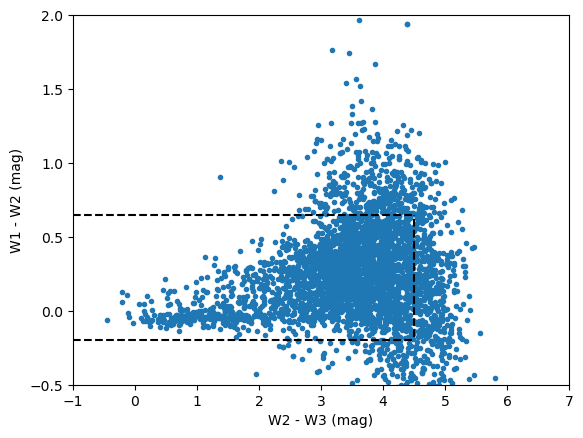

In [46]:
# plot crossmatched WISE galaxies on a color-color plot with conservative cuts on W1-w2 color
w1_w2 = np.array(wise_table['W1mag'] - wise_table['W2mag'])
w2_w3 = np.array(wise_table['W2mag'] - wise_table['W3mag'])
plt.figure()
plt.scatter(w2_w3, w1_w2, marker='.')
plt.xlabel('W2 - W3 (mag)')
plt.ylabel('W1 - W2 (mag)')
plt.axhline(0.65, xmin=0, xmax=0.69, linestyle='--', color='k')
plt.axhline(-0.2, xmin=0, xmax=0.69, linestyle='--', color='k')
plt.axvline(4.5, ymin=0.13, ymax=0.46, linestyle='--', color='k')
plt.ylim(-0.5, 2)
plt.xlim(-1, 7)
plt.show()

In [47]:
# reject dia objects that are nuclear to probable AGN: matches falling outside of the boundary
mask = (w1_w2 > -0.2) & (w1_w2 < 0.65) | (w2_w3 > 4.5)
wise_table_filtered = wise_table[mask]
ned_dia_obj_filtered_wise = ned_dia_obj_match.loc[wise_table_filtered['diaObjectId']]

In [48]:
ned_dia_obj_filtered_wise

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                               
22257345161593080  14.915180 -40.335706            2       -1022.812883   
17451792153446115  16.565758 -46.820388            2          18.061130   
23485156052436712   3.818343 -39.266066            2                NaN   
14210981630574957  29.660207 -50.619965            2                NaN   
12206297055232379  37.403738 -54.774486            2                NaN   
...                      ...        ...          ...                ...   
28833386768367701   0.783577 -32.951258            4         292.674240   
8589384836186149   38.935365 -59.575258            2                NaN   
31668271342157864   3.495615 -30.709533            4       32736.938037   
24802714579894335   8.792441 -38.294803            2                NaN   
27456660771438595   1.351685 -35.074671            6                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
22257345161593080        282.407379    1375.457886        198.857071   
17451792153446115        219.655319    2343.131104        154.733932   
23485156052436712        318.820221    1662.949341        318.820221   
14210981630574957        822.798767   85322.328125        822.798767   
12206297055232379        259.144958    2900.016846        259.144958   
...                             ...            ...               ...   
28833386768367701        326.548584    3883.534180        160.555771   
8589384836186149         236.498199    2500.505615        236.498199   
31668271342157864        460.602386   11955.375977        224.334915   
24802714579894335               NaN            NaN               NaN   
27456660771438595        338.222260    4587.060059        338.222260   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
22257345161593080             2.0       16755.126953            201.687729   
17451792153446115             2.0        6239.419434            155.466339   
23485156052436712             1.0       11986.263672            312.161346   
14210981630574957             1.0      723209.125000            836.990845   
12206297055232379             1.0       14118.125977            265.826660   
...                           ...                ...                   ...   
28833386768367701             4.0       36378.355469            164.274460   
8589384836186149              1.0        8396.978516            241.042679   
31668271342157864             4.0      173858.171875            228.640366   
24802714579894335             NaN                NaN                   NaN   
27456660771438595             1.0       93629.187500            342.161682   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
22257345161593080  ...                NaN               NaN            NaN   
17451792153446115  ...                NaN               NaN            NaN   
23485156052436712  ...                NaN        118.954506    1422.080078   
14210981630574957  ...                NaN        432.404968   44154.261719   
12206297055232379  ...                NaN         99.283791   -2170.282715   
...                ...                ...               ...            ...   
28833386768367701  ...                NaN               NaN            NaN   
8589384836186149   ...                NaN         91.758347    1019.078064   
31668271342157864  ...                NaN               NaN            NaN   
24802714579894335  ...       17955.075861        265.092743   17975.779297   
27456660771438595  ...      202121.420509        241.705933    4927.552734   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean  \
diaObject

In [49]:
def load_and_match_dia_obj_against_milliquas(good_dia_obj, dataset_type="dia_object", radius= 3.0):

    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    wise_table = XMatch.query(cat1=input_table, cat2="vizier:VII/294/catalog", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return wise_table

In [50]:
milliquas_table = load_and_match_dia_obj_against_milliquas(ned_dia_obj_filtered_wise, radius = 3.0)

In [51]:
milliquas_table

<Table length=25>
angDist          ra         ...         Lobe1                  Lobe2        
 arcsec                     ...                                             
float64       float64       ...         str22                  str22        
-------- ------------------ ... ---------------------- ---------------------
0.348974 0.6224371623531597 ...                                             
0.803104 1.3337070327034144 ...                                             
1.997724 3.1072835196006388 ...                                             
 0.62579  8.830852970193964 ...                                             
0.123939  8.977505286452773 ...  4XMM J003554.4-431339                      
0.150463  8.760394636924522 ...  2XMM J003502.4-433420                      
1.199209 31.424670381420338 ...                                             
 0.44928 17.443772462819133 ...  4XMM J010946.2-454655                      
0.434855  36.63681369677567 ...                                             
     ...                ... ...                    ...                   ...
 0.05097  8.766365693942738 ...  4XMM J003503.7-432848                      
1.033404 20.081680757688584 ... SUMSS J012019.8-440741 1RXH J012019.3-440739
0.868815  33.27628854228788 ...                                             
0.916376 33.276424023270245 ...                                             
 0.47574 20.313256118566382 ...                                             
2.689326  9.133278366807236 ...                                             
2.169999 3.9335318437251834 ...                                             
0.121193  9.839099480900924 ...                                             
0.313362 19.534782997542894 ... SUMSS J011808.1-442745

In [52]:
ned_dia_obj_nonAGN = ned_dia_obj_filtered_wise.drop(milliquas_table['diaObjectId'])

In [53]:
ned_dia_obj_nonAGN

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                               
22257345161593080  14.915180 -40.335706            2       -1022.812883   
17451792153446115  16.565758 -46.820388            2          18.061130   
23485156052436712   3.818343 -39.266066            2                NaN   
14210981630574957  29.660207 -50.619965            2                NaN   
12206297055232379  37.403738 -54.774486            2                NaN   
...                      ...        ...          ...                ...   
28833386768367701   0.783577 -32.951258            4         292.674240   
8589384836186149   38.935365 -59.575258            2                NaN   
31668271342157864   3.495615 -30.709533            4       32736.938037   
24802714579894335   8.792441 -38.294803            2                NaN   
27456660771438595   1.351685 -35.074671            6                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
22257345161593080        282.407379    1375.457886        198.857071   
17451792153446115        219.655319    2343.131104        154.733932   
23485156052436712        318.820221    1662.949341        318.820221   
14210981630574957        822.798767   85322.328125        822.798767   
12206297055232379        259.144958    2900.016846        259.144958   
...                             ...            ...               ...   
28833386768367701        326.548584    3883.534180        160.555771   
8589384836186149         236.498199    2500.505615        236.498199   
31668271342157864        460.602386   11955.375977        224.334915   
24802714579894335               NaN            NaN               NaN   
27456660771438595        338.222260    4587.060059        338.222260   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
22257345161593080             2.0       16755.126953            201.687729   
17451792153446115             2.0        6239.419434            155.466339   
23485156052436712             1.0       11986.263672            312.161346   
14210981630574957             1.0      723209.125000            836.990845   
12206297055232379             1.0       14118.125977            265.826660   
...                           ...                ...                   ...   
28833386768367701             4.0       36378.355469            164.274460   
8589384836186149              1.0        8396.978516            241.042679   
31668271342157864             4.0      173858.171875            228.640366   
24802714579894335             NaN                NaN                   NaN   
27456660771438595             1.0       93629.187500            342.161682   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
22257345161593080  ...                NaN               NaN            NaN   
17451792153446115  ...                NaN               NaN            NaN   
23485156052436712  ...                NaN        118.954506    1422.080078   
14210981630574957  ...                NaN        432.404968   44154.261719   
12206297055232379  ...                NaN         99.283791   -2170.282715   
...                ...                ...               ...            ...   
28833386768367701  ...                NaN               NaN            NaN   
8589384836186149   ...                NaN         91.758347    1019.078064   
31668271342157864  ...                NaN               NaN            NaN   
24802714579894335  ...       17955.075861        265.092743   17975.779297   
27456660771438595  ...      202121.420509        241.705933    4927.552734   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean  \
diaObject

## Gaia crossmatch

In [54]:
# check what Gaia DR3 catalogs are available in astroquery.XMatch using the CDS identifier
catalogs_available = XMatch.get_available_tables()
for name in catalogs_available:
    if "I/355" in name:
        print(name)

I/355/paramp
II/355/ugriz-2
I/355/xpsummary
I/355/paramsup
I/355/gaiadr3


In [55]:
def load_and_match_dia_obj_against_gaia(good_dia_obj, dataset_type="dia_object", radius= 3.0):
    
    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    gaia_table = XMatch.query(cat1=input_table, cat2="vizier:I/355/gaiadr3", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return gaia_table

In [56]:
# table of all gaia dr3 sources that crossmatch
gaia_match = load_and_match_dia_obj_against_gaia(ned_dia_obj_nonAGN, radius = 3.0)

In [57]:
gaia_match

<Table length=749>
angDist          ra                 dec         ... e_DEJ2000 RADEcorJ2000
 arcsec                                         ...                       
float64       float64             float64       ...  float64    float32   
-------- ------------------ ------------------- ... --------- ------------
0.725472 29.660207448243767   -50.6199652751624 ...  6.945685       -0.076
0.337544 29.703596503163144  -50.61829025700995 ...  4.612457      -0.1653
0.044739 33.740813468922916  -51.42984213789718 ...  2.243997       -0.163
0.353136 16.222787330212363 -47.016201679975126 ...  0.262003      -0.2946
0.343779  3.754818377760611  -34.04082850614196 ...   0.88446       0.2975
0.814096  7.768177762467737  -36.89273362965434 ...  0.338056       0.2558
1.644592  7.768177762467737  -36.89273362965434 ...  0.466056       0.2645
0.436839 16.847438090939733 -46.987845873710526 ...  0.335145      -0.2837
0.097106  356.7123857671664  -28.86987295605979 ...  2.905705       0.0051
     ...                ...                 ... ...       ...          ...
0.224599 357.05411826917367  -28.19340781999604 ...  1.872633      -0.1104
0.271718  67.88005417874565  -54.80554631721924 ...  2.714696       0.0938
 0.25679 2.1578825830366664  -33.85019685538955 ...   0.79825       0.4091
0.082844 2.9139271966035363 -36.941662761307434 ...  0.478291        0.239
1.329262  345.1248865587605 -10.368592842326631 ...  0.495747       0.1575
0.518662  359.8398682384032 -29.985858973216097 ...  8.212777      -0.0638
0.283022 16.815379343867683  -41.90120525712847 ...  0.354296      -0.5399
0.202473 3.4956147787891787 -30.709532671389645 ...  15.18439      -0.2476
0.685633  8.792440995899618  -38.29480257621243 ...  7.546432       -0.447

In [58]:
gaia_match.columns

<TableColumns names=('angDist','ra','dec','nDiaSources','i_psfFluxMaxSlope','i_psfFluxErrMean','i_psfFluxMean','i_psfFluxMeanErr','i_psfFluxNdata','i_scienceFluxMean','i_scienceFluxMeanErr','i_psfFluxMin','i_psfFluxMax','i_psfFluxSigma','g_psfFluxMaxSlope','g_psfFluxErrMean','g_psfFluxMean','g_psfFluxMeanErr','g_psfFluxNdata','g_scienceFluxMean','g_scienceFluxMeanErr','g_psfFluxMin','g_psfFluxMax','g_psfFluxSigma','diaObjectId','DR3Name','RAdeg','DEdeg','errHalfMaj','errHalfMin','errPosAng','SolID','Source','RandomI','e_RAdeg','e_DEdeg','Plx','e_Plx','RPlx','PM','pmRA','e_pmRA','pmDE','e_pmDE','RADEcor','RAPlxcor','RApmRAcor','RApmDEcor','DEPlxcor','DEpmRAcor','DEpmDEcor','PlxpmRAcor','PlxpmDEcor','pmRApmDEcor','NAL','NAC','NgAL','NbAL','gofAL','chi2AL','epsi','sepsi','Solved','APF','nueff','pscol','e_pscol','RApscolCorr','DEpscolCorr','PlxpscolCorr','pmRApscolCorr','pmDEpscolCorr','MatchObsA','Nper','amax','MatchObs','IPDgofha','IPDgofhp','IPDfmp','IPDfow','RUWE','Dup','o_Gmag','FG','

In [59]:
# filter out sources likely to be stellar based on measured parallax (can change these cuts)
mask = (gaia_match['Plx'] is not None) & (gaia_match['e_Plx'] < 1.0)
gaia_stars = gaia_match[mask]

In [60]:
gaia_stars

<Table length=362>
angDist          ra                 dec         ... e_DEJ2000 RADEcorJ2000
 arcsec                                         ...                       
float64       float64             float64       ...  float64    float32   
-------- ------------------ ------------------- ... --------- ------------
0.725472 29.660207448243767   -50.6199652751624 ...  6.945685       -0.076
0.353136 16.222787330212363 -47.016201679975126 ...  0.262003      -0.2946
0.343779  3.754818377760611  -34.04082850614196 ...   0.88446       0.2975
0.814096  7.768177762467737  -36.89273362965434 ...  0.338056       0.2558
1.644592  7.768177762467737  -36.89273362965434 ...  0.466056       0.2645
0.436839 16.847438090939733 -46.987845873710526 ...  0.335145      -0.2837
0.296516  9.134823049858722  -43.50858484183092 ...  0.449286      -0.1579
2.052833  9.134823049858722  -43.50858484183092 ...  0.403299      -0.1691
0.681765  5.824467369811777  -40.12038249510045 ...  1.407664       0.1318
     ...                ...                 ... ...       ...          ...
0.574558  340.3925123228543  0.4133897546207079 ...  0.786356        0.185
0.386555  357.0856298907922 -28.231782494015278 ...  8.490028       0.0617
0.364446 2.1617743851732616 -33.850009678384964 ...  1.763727       0.4256
0.271718  67.88005417874565  -54.80554631721924 ...  2.714696       0.0938
 0.25679 2.1578825830366664  -33.85019685538955 ...   0.79825       0.4091
0.082844 2.9139271966035363 -36.941662761307434 ...  0.478291        0.239
1.329262  345.1248865587605 -10.368592842326631 ...  0.495747       0.1575
0.518662  359.8398682384032 -29.985858973216097 ...  8.212777      -0.0638
0.283022 16.815379343867683  -41.90120525712847 ...  0.354296      -0.5399

In [64]:
# remove stellar sources from the crossmatched NED table
ned_dia_obj_filtered_gaia = ned_dia_obj_nonAGN.drop(gaia_stars['diaObjectId'])
ned_dia_obj_filtered_gaia

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                               
22257345161593080  14.915180 -40.335706            2       -1022.812883   
17451792153446115  16.565758 -46.820388            2          18.061130   
23485156052436712   3.818343 -39.266066            2                NaN   
12206297055232379  37.403738 -54.774486            2                NaN   
14210981630574974  29.703597 -50.618290            2                NaN   
...                      ...        ...          ...                ...   
28833386768367701   0.783577 -32.951258            4         292.674240   
8589384836186149   38.935365 -59.575258            2                NaN   
31668271342157864   3.495615 -30.709533            4       32736.938037   
24802714579894335   8.792441 -38.294803            2                NaN   
27456660771438595   1.351685 -35.074671            6                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
22257345161593080        282.407379    1375.457886        198.857071   
17451792153446115        219.655319    2343.131104        154.733932   
23485156052436712        318.820221    1662.949341        318.820221   
12206297055232379        259.144958    2900.016846        259.144958   
14210981630574974               NaN            NaN               NaN   
...                             ...            ...               ...   
28833386768367701        326.548584    3883.534180        160.555771   
8589384836186149         236.498199    2500.505615        236.498199   
31668271342157864        460.602386   11955.375977        224.334915   
24802714579894335               NaN            NaN               NaN   
27456660771438595        338.222260    4587.060059        338.222260   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
22257345161593080             2.0       16755.126953            201.687729   
17451792153446115             2.0        6239.419434            155.466339   
23485156052436712             1.0       11986.263672            312.161346   
12206297055232379             1.0       14118.125977            265.826660   
14210981630574974             NaN                NaN                   NaN   
...                           ...                ...                   ...   
28833386768367701             4.0       36378.355469            164.274460   
8589384836186149              1.0        8396.978516            241.042679   
31668271342157864             4.0      173858.171875            228.640366   
24802714579894335             NaN                NaN                   NaN   
27456660771438595             1.0       93629.187500            342.161682   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
22257345161593080  ...                NaN               NaN            NaN   
17451792153446115  ...                NaN               NaN            NaN   
23485156052436712  ...                NaN        118.954506    1422.080078   
12206297055232379  ...                NaN         99.283791   -2170.282715   
14210981630574974  ...       5.064735e+06        159.353439    1860.833374   
...                ...                ...               ...            ...   
28833386768367701  ...                NaN               NaN            NaN   
8589384836186149   ...                NaN         91.758347    1019.078064   
31668271342157864  ...                NaN               NaN            NaN   
24802714579894335  ...       1.795508e+04        265.092743   17975.779297   
27456660771438595  ...       2.021214e+05        241.705933    4927.552734   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean  \
diaObject

## Filter out Solar System Objects using SSObjectId

In [67]:
# get dia sources for the dia objects passing our filtering
common_dia_objids = set(dia_srcs_inside['diaObjectId'].to_list()).intersection(set(ned_dia_obj_filtered_gaia.index))
ned_dia_src_filtered_gaia = dia_srcs_inside[dia_srcs_inside['diaObjectId'].isin(common_dia_objids)]

In [74]:
# filter out any dia source that has an ssObjectId that is not 0
idxs = np.nonzero(ned_dia_src_filtered_gaia['ssObjectId'])
idxs

(array([], dtype=int64),)

No dia sources with ssObjectIds associated.

## Distance consistency (LS crossmatch / distant galaxies in the refcat)

There are 2800 candidates that pass our crossmatching cuts. We can reduce them to a reasonable number by removing candidates on top of distant galaxies, since this event is at 92 Mpc.


In [ ]:
# 0.8 " is a typical size for galaxy in Rubin
# 0.145 kpc / arcsec appropriate for the distance to the galaxy
# discard hosts that < 1 " across -- unlikely to be associated??

In [80]:
# remove dia sources for which extendedness=1 (galaxy-like vs point source-like)
mask = ned_dia_src_filtered_gaia['extendedness'] < 1.0
ned_dia_src_filtered = ned_dia_src_filtered_gaia[mask]

In [84]:
# keep only dia objects for which dia sources have extendedness < 1
common_dia_objids = set(ned_dia_src_filtered['diaObjectId'].to_list()).intersection(set(ned_dia_obj_filtered_gaia.index))
ned_dia_obj_filtered = ned_dia_obj_filtered_gaia[ned_dia_obj_filtered_gaia.index.isin(common_dia_objids)]

In [85]:
ned_dia_obj_filtered

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                                
17451792153446115   16.565758 -46.820388            2       1.806113e+01   
12206297055232379   37.403738 -54.774486            2                NaN   
14214005287551363   33.740813 -51.429842            7       2.971694e+06   
14214005287551370   33.705158 -51.451603            4       3.849729e+02   
14214005287551576   33.733449 -51.422503            4       1.325553e+06   
...                       ...        ...          ...                ...   
30240349335060527    1.585984 -31.958754            3       1.787538e+03   
34572493867975175  358.068139 -28.286909            2       8.669520e+01   
31663048661925894    1.048887 -30.457257            2                NaN   
28833386768367701    0.783577 -32.951258            4       2.926742e+02   
8589384836186149    38.935365 -59.575258            2                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
17451792153446115        219.655319    2343.131104        154.733932   
12206297055232379        259.144958    2900.016846        259.144958   
14214005287551363        390.586609    5012.314453        174.551575   
14214005287551370        296.203064    4393.346191        209.445572   
14214005287551576        303.423706    2733.239746        174.192245   
...                             ...            ...               ...   
30240349335060527        299.878937    3673.402588        169.668457   
34572493867975175        337.124695    3953.017090        227.258255   
31663048661925894        268.091522     -27.330111        268.091522   
28833386768367701        326.548584    3883.534180        160.555771   
8589384836186149         236.498199    2500.505615        236.498199   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
17451792153446115             2.0        6239.419434            155.466339   
12206297055232379             1.0       14118.125977            265.826660   
14214005287551363             5.0      102878.554688            177.330200   
14214005287551370             2.0       27263.708984            210.881973   
14214005287551576             3.0       31171.611328            178.307159   
...                           ...                ...                   ...   
30240349335060527             3.0       29431.027344            171.892578   
34572493867975175             2.0       25212.421875            231.153992   
31663048661925894             1.0       28590.505859            272.763336   
28833386768367701             4.0       36378.355469            164.274460   
8589384836186149              1.0        8396.978516            241.042679   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
17451792153446115  ...                NaN               NaN            NaN   
12206297055232379  ...                NaN         99.283791   -2170.282715   
14214005287551363  ...        -140.358776        133.880524   -1603.374634   
14214005287551370  ...        -298.860431        116.961899   -1198.924683   
14214005287551576  ...                NaN         95.750648   -1031.102051   
...                ...                ...               ...            ...   
30240349335060527  ...                NaN               NaN            NaN   
34572493867975175  ...                NaN               NaN            NaN   
31663048661925894  ...                NaN        127.179520    1640.682007   
28833386768367701  ...                NaN               NaN            NaN   
8589384836186149   ...                NaN         91.758347    1019.078064   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean 

In [86]:
ned_dia_obj_filtered.to_csv("../data/S251112cm_dia_objects_filtered_v1.csv")

In [87]:
def load_and_match_dia_obj_against_decals(good_dia_obj, dataset_type="dia_object", radius=3):
    
    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    decals_table = XMatch.query(cat1=input_table, cat2="vizier:VII/292/south", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return decals_table

In [95]:
# set a conservative physical matching radius
z = z_at_value(cosmo.luminosity_distance, 93 * u.Mpc)
matching_radius_physical = 5 * u.kpc
matching_radius_angular = matching_radius_physical * cosmo.arcsec_per_kpc_proper(z)
print(matching_radius_physical, matching_radius_angular)

5.0 kpc 11.55255342076482 arcsec


In [96]:
# crossmatch against DECaLS DR8 phot-z catalog
decals_table = load_and_match_dia_obj_against_decals(ned_dia_obj_filtered, radius=10)

In [97]:
decals_table

<Table length=3768>
angDist          ra                 dec         ... e_zphot fclean fqual
 arcsec                                         ...                     
float64       float64             float64       ... float32 uint8  uint8
-------- ------------------ ------------------- ... ------- ------ -----
5.064776 0.7513007134761392  -32.95952849282845 ...   0.524      1     0
7.446021 0.7513007134761392  -32.95952849282845 ...   0.153      1     1
9.180083 0.7513007134761392  -32.95952849282845 ...   0.872      1     0
9.602483 0.7513007134761392  -32.95952849282845 ...   0.058      1     1
0.699825  343.1217943059573 -11.092263251138506 ...    1.77      0     0
1.148062  343.1217943059573 -11.092263251138506 ...   0.011      0     0
9.618193  343.1217943059573 -11.092263251138506 ...   0.596      0     0
0.855125 340.74081223882456  -2.084825070781051 ...   0.014      1     1
 7.73502 340.74081223882456  -2.084825070781051 ...     0.1      0     0
     ...                ...                 ... ...     ...    ...   ...
7.773888  1.585983636105605 -31.958753897444165 ...   0.277      1     1
0.345881 0.7835768423788817   -32.9512578023393 ...   0.049      1     1
2.209793 0.7835768423788817   -32.9512578023393 ...   0.148      0     0
0.588971 38.935364859420964  -59.57525814744734 ...   0.073      1     1
3.798087 38.935364859420964  -59.57525814744734 ...   0.101      1     1
4.396321 38.935364859420964  -59.57525814744734 ...   0.049      1     1
5.105277 38.935364859420964  -59.57525814744734 ...   0.518      1     0
9.147152 38.935364859420964  -59.57525814744734 ...   0.082      1     1
9.438212 38.935364859420964  -59.57525814744734 ...   0.247      1     1

In [92]:
decals_table.columns

<TableColumns names=('angDist','ra','dec','nDiaSources','i_psfFluxMaxSlope','i_psfFluxErrMean','i_psfFluxMean','i_psfFluxMeanErr','i_psfFluxNdata','i_scienceFluxMean','i_scienceFluxMeanErr','i_psfFluxMin','i_psfFluxMax','i_psfFluxSigma','g_psfFluxMaxSlope','g_psfFluxErrMean','g_psfFluxMean','g_psfFluxMeanErr','g_psfFluxNdata','g_scienceFluxMean','g_scienceFluxMeanErr','g_psfFluxMin','g_psfFluxMax','g_psfFluxSigma','diaObjectId','id','RAdeg','DEdeg','release','brickid','objid','type','pstar','gmmcomp','zphot','e_zphot','fclean','fqual')>

In [100]:
# remove objects that crossmatch to within 10" of a DECaLS galaxy that has photo-z > 0.3
good_photoz = (decals_table['pstar'] < 0.5) & (decals_table['zphot'] < 0.3)
decals_table[good_photoz]

<Table length=595>
angDist          ra                 dec         ... e_zphot fclean fqual
 arcsec                                         ...                     
float64       float64             float64       ... float32 uint8  uint8
-------- ------------------ ------------------- ... ------- ------ -----
1.148062  343.1217943059573 -11.092263251138506 ...   0.011      0     0
0.855125 340.74081223882456  -2.084825070781051 ...   0.014      1     1
0.427405 10.769209057734967 -39.281100237105015 ...   0.015      0     0
0.349657  5.235657059077603  -32.56606442857953 ...   0.057      1     1
1.295491  340.7403055256096  -2.075383605590408 ...   0.014      0     0
0.202427  344.1404427426509  -9.089053608813085 ...   0.044      1     1
0.133718  9.932247228878834 -43.788197865917994 ...   0.029      1     1
0.185394 18.476065799971824  -45.16883497554943 ...   0.019      1     1
 0.44134  31.59177521137148 -52.001702471031116 ...   0.048      1     1
     ...                ...                 ... ...     ...    ...   ...
0.494853 0.5126617184018684  -36.09836498097718 ...   0.032      1     1
0.866426  17.07188130807488  -46.16440109596401 ...   0.014      1     1
0.204842 36.301200738219876  -51.87398263623452 ...   0.075      1     1
1.221911   4.83609441721485  -34.88589536975498 ...   0.026      1     1
0.456824  38.99706108274863  -51.34581311967465 ...    0.13      0     0
0.178676 0.5024519093677227  -36.09524433294832 ...   0.061      1     1
0.089466  39.27161690680522  -54.60033784549458 ...    0.05      1     1
0.915356   17.0745596821854  -46.15241323669991 ...   0.018      1     1
0.345881 0.7835768423788817   -32.9512578023393 ...   0.049      1     1

In [101]:
# save the dia objects that have photo-zs < 0.3 from DECaLS
ned_dia_obj_filtered_LS = ned_dia_obj_filtered.loc[np.unique(decals_table[good_photoz]['diaObjectId'])]

In [102]:
ned_dia_obj_filtered_LS

ra        dec  nDiaSources  i_psfFluxMaxSlope  \
diaObjectId                                                                
9430305073004630    34.901863 -59.141627            3         191.707647   
9430305073004635    34.915138 -59.157244            4         595.528953   
9430305073004678    34.952079 -59.162805            3        2660.622573   
11230617924534289   30.328288 -56.129014            2                NaN   
11230617924534291   30.265625 -56.123603            4        -463.773060   
...                       ...        ...          ...                ...   
66650195852525603  338.644474   1.341487            2                NaN   
66658785787117613  342.414772   0.193382            2        -540.007697   
66658991945547821  342.010923   0.092042            2       -1346.672307   
66659266823454776  342.939589   0.307102            3                NaN   
66661465846710365  342.691922   0.818957            2                NaN   

                   i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  \
diaObjectId                                                            
9430305073004630         272.229034    2867.628662        156.027954   
9430305073004635         283.576538    4264.681641        140.727005   
9430305073004678         313.679840    3465.305664        180.530060   
11230617924534289        311.643524    3218.416748        311.643524   
11230617924534291        304.782013    3827.003662        214.157913   
...                             ...            ...               ...   
66650195852525603        454.901581    6075.620605        454.901581   
66658785787117613        358.530304    4501.293945        249.144882   
66658991945547821        477.072357    3790.022461        281.889038   
66659266823454776        414.214386    4182.850098        414.214386   
66661465846710365        408.268677   -1096.194946        408.268677   

                   i_psfFluxNdata  i_scienceFluxMean  i_scienceFluxMeanErr  \
diaObjectId                                                                  
9430305073004630              3.0       15277.860352            159.637604   
9430305073004635              4.0       29842.357422            143.608475   
9430305073004678              3.0       46873.656250            184.019440   
11230617924534289             1.0       13901.125977            319.732300   
11230617924534291             2.0       28354.847656            218.488190   
...                           ...                ...                   ...   
66650195852525603             1.0      103433.312500            464.597992   
66658785787117613             2.0       32434.285156            252.910294   
66658991945547821             2.0       43729.546875            289.257629   
66659266823454776             1.0      125285.132812            421.982758   
66661465846710365             1.0      104129.257812            417.743286   

                   ...  g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  \
diaObjectId        ...                                                       
9430305073004630   ...                NaN               NaN            NaN   
9430305073004635   ...                NaN               NaN            NaN   
9430305073004678   ...                NaN               NaN            NaN   
11230617924534289  ...                NaN        103.530533     400.510132   
11230617924534291  ...         183.026767        123.918907     726.194092   
...                ...                ...               ...            ...   
66650195852525603  ...                NaN        210.622375     607.733887   
66658785787117613  ...                NaN               NaN            NaN   
66658991945547821  ...                NaN               NaN            NaN   
66659266823454776  ...          71.319621        156.780518    2009.468750   
66661465846710365  ...                NaN        174.749695    2435.176270   

                   g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean 

In [ ]:
ned_dia_obj_filtered_LS.to_csv("../S251112cm_dia_objects_filtered_photoz_v1.csv")

## Check common objects between Rubin-Rubin and DECam-Rubin

In [15]:
ned_dia_obj_filtered = pd.read_csv("../data/S251112cm_dia_objects_filtered_v1.csv")
rubin2_candidates = pd.read_csv("../data/Rubin_rubin_final.csv")
dia_objs_inside = pd.read_csv("../data/dia_obj_inside95_S251112cm.csv")
ned_dia_obj = pd.read_csv("../data/dia_obj_match_116arcsec_S251112cm.csv")

In [18]:
ned_dia_obj_filtered

diaObjectId          ra        dec  nDiaSources  i_psfFluxMaxSlope  \
0    11255082058252346   39.328807 -55.239719            2       1.292972e+06   
1    19800348990374235   18.584639 -44.072763            2                NaN   
2    17451723433967757   16.826403 -46.826682            3      -1.082016e+07   
3    19801036185141411   18.585113 -44.048371            2                NaN   
4    20990501607964860   10.406834 -42.339568            2       8.465843e+04   
..                 ...         ...        ...          ...                ...   
232  17463405745012747   21.129237 -47.288655            2                NaN   
233  17470758729023491   23.900355 -47.107229            2                NaN   
234  28830637989298184    0.724686 -33.635313            2                NaN   
235  19776503331946551    9.900110 -43.322802            2      -6.792830e+06   
236  36052505238437892  356.931052 -27.720293            2                NaN   

     i_psfFluxErrMean  i_psfFluxMean  i_psfFluxMeanErr  i_psfFluxNdata  \
0           319.45770    3498.286621        225.665527             2.0   
1           377.95044    3933.136230        377.950439             1.0   
2           355.76196   11140.482422        249.800613             2.0   
3           323.09120   -4572.466797        323.091187             1.0   
4           332.17603    3052.835938        234.698013             2.0   
..                ...            ...               ...             ...   
232         317.79260    5235.083496        317.792603             1.0   
233         513.61350   38070.343750        513.613525             1.0   
234         390.20154    7812.134766        390.201538             1.0   
235         356.71210    3384.712891        247.420685             2.0   
236         452.80078   -3489.376221        452.800781             1.0   

     i_scienceFluxMean  ...  g_psfFluxMaxSlope  g_psfFluxErrMean  \
0         14413.568359  ...                NaN               NaN   
1         30362.986328  ...                NaN         183.05008   
2         33424.460938  ...                NaN         165.04932   
3         21849.287109  ...                NaN         172.06256   
4         24236.558594  ...                NaN               NaN   
..                 ...  ...                ...               ...   
232       31063.304688  ...                NaN         150.63492   
233      252471.843750  ...                NaN         361.01276   
234       74084.804688  ...                NaN         180.39390   
235       32323.904297  ...                NaN               NaN   
236       51545.367188  ...                NaN         138.97026   

     g_psfFluxMean  g_psfFluxMeanErr  g_psfFluxNdata  g_scienceFluxMean  \
0              NaN               NaN             NaN                NaN   
1     16758.539062        183.050079             1.0        9020.616211   
2      -256.943146        165.049316             1.0       20308.892578   
3      4126.978516        172.062561             1.0        1275.859253   
4              NaN               NaN             NaN                NaN   
..             ...               ...             ...                ...   
232    3319.340088        150.634918             1.0       13339.472656   
233    -180.695770        361.012756             1.0      175013.984375   
234    2016.116333        180.393906             1.0       36542.917969   
235            NaN               NaN             NaN                NaN   
236    1423.365845        138.970261             1.0        6029.141113   

     g_scienceFluxMeanErr  g_psfFluxMin  g_psfFluxMax  g_psfFluxSigma  
0                     NaN           NaN           NaN             NaN  
1              190.848694  16758.539062  16758.539062             NaN  
2              172.143509   -256.943146   -256.943146             NaN  
3              179.154556   4126.978516   4126.978516             NaN  
4                     NaN           NaN           NaN             NaN  

In [19]:
rubin2_candidates

<Table length=166>
angDist  angDist2          ra         ...      coord_dec         diaSourceId   
float64  float64        float64       ...       float64             int64      
------- ---------- ------------------ ... ------------------- -----------------
    0.0   2.136918   342.909106213336 ...  -5.557728549286056 25499889983029251
    0.0   2.136918   342.909106213336 ...  -5.557728549286056 25499905283850242
    0.0 138.104422  343.4655928223319 ...  -6.612393376550387 25499905274937396
    0.0 138.104422  343.4655928223319 ...  -6.612393376550387 25499905808662566
    0.0 142.080009 343.50724532338955 ...  -6.611170725646394 25499905274937401
    0.0 142.080009 343.50724532338955 ...  -6.611170725646394 25499905810235418
    0.0 144.045307 345.71686670153684 ...   -8.40957289903682 25499890537725984
    0.0 144.045307 345.71686670153684 ...   -8.40957289903682 25499891533348902
    0.0  85.878295 346.31986849290456 ... -10.232602584555357 25499890929893425
    ...        ...                ... ...                 ...               ...
    0.0  45.204127  78.73599759282196 ...  -55.04022968962958 25499888384999452
    0.0  45.204127  78.73599759282196 ...  -55.04022968962958 25499888439001112
    0.0    0.59925  39.16125808517619 ... -54.859941377000645 25499902608932902
    0.0    0.59925  39.16125808517619 ... -54.859941377000645 25499902432247822
    0.0   0.364733  39.08325603153436 ...   -54.8641571452959 25499887109931018
    0.0   0.364733  39.08325603153436 ...   -54.8641571452959 25499887322791953
    0.0   0.414052  32.63348059041873 ...  -53.83671183948608 25499886642266162
    0.0   0.414052  32.63348059041873 ...  -53.83671183948608 25499901949378566
    0.0   0.099642 30.290124987995934 ...  -56.12593428991626 25499886374879250
    0.0   0.099642 30.290124987995934 ...  -56.12593428991626 25499901681991700

In [19]:
rubin2_objs = rubin2_candidates.drop_duplicates(subset=['ra', 'dec'])
rubin2_objs

angDist    angDist2          ra        dec  nDiaSources  \
0        0.0    2.136918  342.909106  -5.557729            2   
2        0.0  138.104422  343.465593  -6.612393            2   
4        0.0  142.080009  343.507245  -6.611171            2   
6        0.0  144.045307  345.716867  -8.409573            2   
8        0.0   85.878295  346.319868 -10.232603            2   
10       0.0   41.373611  346.170299  -9.653185            2   
12       0.0  139.283935  346.104735  -9.595400            2   
14       0.0  143.959182  345.762084  -9.017147            2   
16       0.0  147.846315  345.689843  -8.951014            2   
18       0.0  132.421517  350.418340 -11.583395            2   
20       0.0   93.649927  350.402584 -11.532899            2   
22       0.0   69.895579  343.500380 -10.903708            2   
24       0.0    0.391966  350.646858 -13.094044            2   
26       0.0  124.611713  347.994679 -12.833269            2   
28       0.0  149.069928  347.964561 -12.774319            2   
30       0.0  138.469341  347.125452 -12.647695            2   
32       0.0    1.167007  347.187013 -12.639697            2   
34       0.0   85.954336  347.161021 -12.618083            2   
38       0.0   11.404680  346.515587 -12.164754            2   
40       0.0  101.739147  356.925241 -28.717833            2   
42       0.0   27.308438  357.059293 -28.531582            2   
44       0.0   15.340241  357.113932 -28.279079            2   
48       0.0  145.892724  357.895818 -31.327435            2   
50       0.0    0.049818    4.519519 -33.874611            2   
56       0.0   49.981471    2.148450 -33.844984            2   
58       0.0   60.818412    2.161576 -33.849932            3   
61       0.0   45.453716  357.619933 -34.300052            2   
63       0.0    0.086103    1.277887 -35.694924            2   
65       0.0  120.674886    1.092628 -34.708750            2   
67       0.0   62.500043    1.150051 -34.706282            2   
69       0.0    0.099812    2.567911 -36.863012            2   
75       0.0    0.110285    1.502984 -36.119762            4   
80       0.0   12.051407    1.490938 -36.135392            2   
92       0.0    0.441737    1.500472 -36.112309            2   
97       0.0  145.278594    1.322977 -35.963390            2   
99       0.0   54.589431    8.546462 -37.890680            2   
103      0.0    1.218743    8.567681 -37.887362            2   
107      0.0   55.057532    9.817893 -43.060303            2   
110      0.0    0.467329   10.415740 -42.320988            2   
112      0.0    0.353898   14.239936 -43.838814            3   
114      0.0    0.394411   18.403921 -45.335284            2   
116      0.0    0.656193   17.527438 -45.931814            2   
128      0.0    0.739802   25.570389 -47.530073            2   
130      0.0    0.110229   21.122365 -47.363351            3   
132      0.0    0.123580   16.797105 -47.066170            3   
134      0.0   25.192918   16.805883 -46.837928            4   
136      0.0    1.020170   16.104005 -46.502132            2   
138      0.0    0.456720   16.735488 -46.216299            2   
142      0.0  148.874309   26.398000 -48.139452            3   
145      0.0    2.313691   33.276116 -50.508141            2   
147      0.0    1.028509   18.979823 -50.189339            2   
149      0.0   22.232254   39.007018 -51.345817            2   
153      0.0   71.746139   31.404597 -52.786385            3   
156      0.0   45.204127   78.735998 -55.040230            2   
158      0.0    0.599250   39.161258 -54.859941            2   
160      0.0    0.364733   39.083256 -54.864157            2   
162      0.0    0.414052   32.633481 -53.836712            2   
164      0.0    0.099642   30.290125 -56.125934            2   

     g_psfFluxMaxSlope  g_psfFluxErrMean  g_psfFluxMean  g_psfFluxMeanErr  \
0                  NaN        487.767487    8363.199219        487.767487   
2                  NaN               NaN            NaN               NaN 

In [20]:
def load_and_match_dia_objs(good_dia_obj, good_dia_obj2, dataset_type="dia_object", radius= 3.0):

    input_table = Table.from_pandas(good_dia_obj)
    input_table2 = Table.from_pandas(good_dia_obj2)
    # input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    matched_table = XMatch.query(cat1=input_table, cat2=input_table2, max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec', colRA2='ra', colDec2='dec')
    
    return matched_table

In [21]:
matched_dia_obj = load_and_match_dia_objs(ned_dia_obj, rubin2_objs, radius=3.0)

In [22]:
matched_dia_obj

<Table length=8>
angDist     diaObjectId    ...      coord_dec         diaSourceId   
 arcsec                    ...                                      
float64        int64       ...       float64             int64      
-------- ----------------- ... ------------------- -----------------
0.437886 34565347042394147 ...  -28.27907946167205 25499909806882818
0.776529 17451723433967726 ...  -46.83792811217026 25499900148449310
1.306383 14235033447432196 ...  -51.34581734362924 25499887449145350
0.893542 28836272986390546 ...  -33.84993235594687 25499895498014793
1.481096 17453303981932574 ...  -46.50213204390178 25499899774107687
0.246465 24804844883673118 ... -37.887361786387935 25499896231493636
0.644516 26104192749797386 ...  -36.13539248029623 25499895427760133
1.199331 19788048204038152 ... -43.838814242426665 25499884157665329

In [23]:
matched_dia_obj.write("matched_dia_objects.csv", format="csv")

8 common matches!

## Image cutouts

In [4]:
# If jumping directly to image cutout generation, uncomment this cell
ned_dia_obj_filtered = pd.read_csv("../data/S251112cm_dia_objects_filtered_v0.csv")
dia_srcs_inside = pd.read_csv("../data/dia_srcs_inside_S251112cm.csv")

In [13]:
np.amin(good_dia_srcs['midpointMjdTai']), np.amax(good_dia_srcs['midpointMjdTai'])

(60996.05642473414, 60997.04508245519)

In [5]:
# get dia sources for the dia objects for viewing cutouts
common_dia_objids = set(dia_srcs_inside['diaObjectId'].to_list()).intersection(set(ned_dia_obj_filtered['diaObjectId'].to_list()))
ned_dia_src_filtered = dia_srcs_inside[dia_srcs_inside['diaObjectId'].isin(common_dia_objids)]

In [6]:
ned_dia_src_filtered = ned_dia_src_filtered.reset_index()
ned_dia_src_filtered

index        diaSourceId          visit  detector band  \
0     13862  25499902436442113  2025111600214        81    i   
1     13863  25499902436442127  2025111600214        81    i   
2     13880  25499902609457181  2025111600215       155    i   
3     15996  25499887943024646  2025111600106        85    g   
4     15998  25499903245418501  2025111600220        88    i   
..      ...                ...            ...       ...  ...   
312  355190  25499892286750731  2025111600138       178    g   
313  361693  25499909026218007  2025111600263       106    i   
314  399604  25499906833645576  2025111600247        20    i   
315  400220  25499905837498378  2025111600239       168    i   
316  400226  25499906836267021  2025111600247        25    i   

           diaObjectId  ssObjectId  parentDiaSourceId  midpointMjdTai  \
0    11255082058252346           0                  0    60996.142607   
1    11255082058252349           0                  0    60996.142607   
2    11255082058252346           0                  0    60996.143065   
3    11344554816962567           0                  0    60996.075233   
4    11344554816962567           0                  0    60996.145712   
..                 ...         ...                ...             ...   
312  42153351663583245           0                  0    60996.093509   
313  43740015661940746           0                  0    60996.168634   
314  56688276907491362           0                  0    60996.160536   
315  56695492452548619           0                  0    60996.156565   
316  56695492452548619           0                  0    60996.160536   

     bboxSize  ...  pixelFlags_streak  pixelFlags_streakCenter  \
0          15  ...              False                    False   
1          19  ...              False                    False   
2          16  ...              False                    False   
3          36  ...              False                    False   
4          25  ...              False                    False   
..        ...  ...                ...                      ...   
312        15  ...              False                    False   
313        36  ...              False                    False   
314        62  ...              False                    False   
315        24  ...              False                    False   
316        28  ...              False                    False   

     pixelFlags_injected  pixelFlags_injectedCenter  \
0                  False                      False   
1                  False                      False   
2                  False                      False   
3                  False                      False   
4                  False                      False   
..                   ...                        ...   
312                False                      False   
313                False                      False   
314                False                      False   
315                False                      False   
316                False                      False   

     pixelFlags_injected_template  pixelFlags_injected_templateCenter  \
0                           False                               False   
1                           False                               False   
2                           False                               False   
3                           False                               False   
4                           False                               False   
..                            ...                                 ...   
312                         False                               False   
313                         False                               False   
314                         False                               False   
315                         False                               False   
316                         False                               False   

     pixelFlags_nodata  pixel

In [10]:
ned_dia_src_filtered.to_csv("../data/S251112cm_dia_sources_filtered_v0.csv")

In [19]:
repo = "/repo/embargo"
collection = "u/elhoward/TOO/S251112cm/Rubin-DECam/associated"
butler = Butler(repo, collections=collection)

In [7]:
print(f"Generate stamps for matches")    

# matches_path = 'ned_dia_src_filtered.csv'
matches = ned_dia_src_filtered.copy()
# matches = ned_dia_src_filtered.drop_duplicates(subset=['diaSourceId'])
matches['instrument'] = 'LSSTCam' # instrument is also needed

cutoutConfigDrp = PlotImageSubtractionCutoutsConfig()
cutoutConfigDrp.sizes = [51] # each postage stamp is 51x51
cutoutConfigDrp.add_metadata = True
cutoutConfigDrp.save_as_numpy = False #only save the .png files
## the type of images is very limited, and it's not possible to change name of template image. (template_detector)
## You will need to change the plotImageSubtractionCutouts.py if the exposures have a different name
cutoutConfigDrp.science_image_type = "preliminary_visit_image" 
cutoutConfigDrp.diff_image_type = "difference_image"

output_path = '/home/s/sanand08/notebooks/ToO-analysis-tools/data/Rubin_DECam_candidate_cutouts/'

matches['diaSourceId'] = matches['diaSourceId'].astype(int)

# Define the batch size
# if the file is not too large this is not needed
batch_size = 100

# Calculate the number of batches needed
num_batches = np.ceil(len(matches) / batch_size)
print(int(num_batches))

for i, batch in enumerate(matches.groupby(matches.index // batch_size)):
    print(len(batch[1]))
    cutoutTaskDrp = PlotImageSubtractionCutoutsTask(config=cutoutConfigDrp, 
                                                    output_path=output_path)
    cutoutTaskDrp.run(batch[1][['diaSourceId', 'visit', 'detector', 'instrument', 'ra', 
                                'dec']], butler)
    gc.collect()

print('DONE!')


Generate stamps for matches
4
100


100


17


DONE!


##  Lightcurve visualization

In [ ]:
ned_dia_obj_filtered = pd.read_csv("../data/S251112cm_dia_objects_filtered_v0.csv")
ned_dia_src_filtered = pd.read_csv("../data/S251112cm_dia_sources_filtered_v0.csv")

In [11]:
ned_dia_src_filtered.columns

Index(['index', 'diaSourceId', 'visit', 'detector', 'band', 'diaObjectId',
       'ssObjectId', 'parentDiaSourceId', 'midpointMjdTai', 'bboxSize',
       'timeProcessedMjdTai', 'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psfFlux',
       'psfFluxErr', 'psfChi2', 'psfNdata', 'trailFlux', 'trailFluxErr',
       'trailRa', 'trailDec', 'trailLength', 'trailAngle', 'dipoleMeanFlux',
       'dipoleMeanFluxErr', 'dipoleFluxDiff', 'dipoleFluxDiffErr',
       'dipoleLength', 'dipoleAngle', 'dipoleChi2', 'isDipole', 'isNegative',
       'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr',
       'templateFlux', 'templateFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF', 'extendedness', 'reliability', 'glint_trail',
       'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 

In [39]:
np.amax(ned_dia_src_filtered['midpointMjdTai']), np.amin(ned_dia_src_filtered['midpointMjdTai'])

(60996.17238416603, 60996.05642473414)

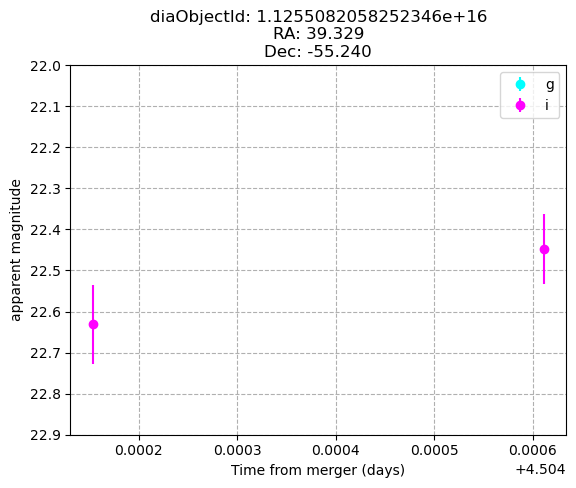

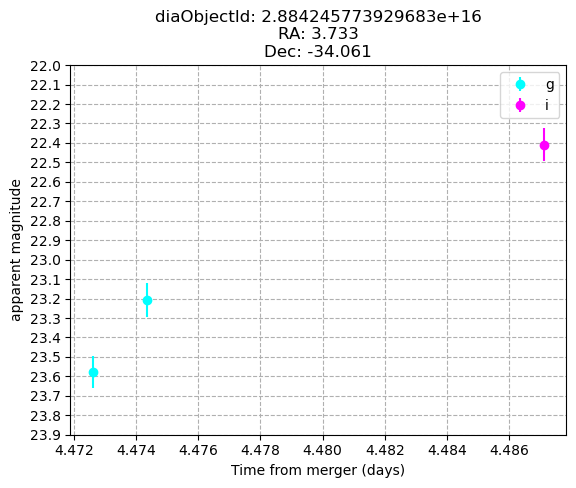

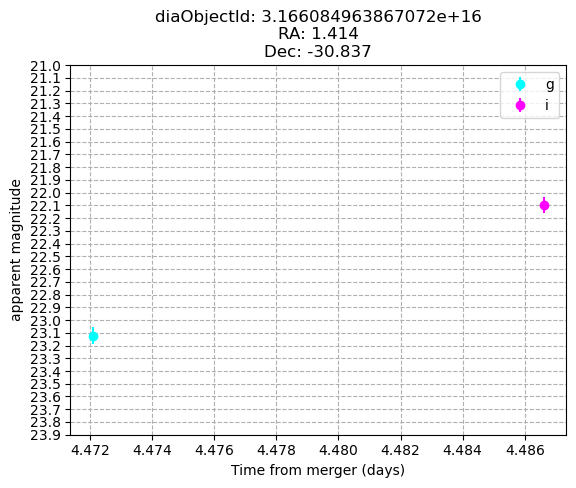

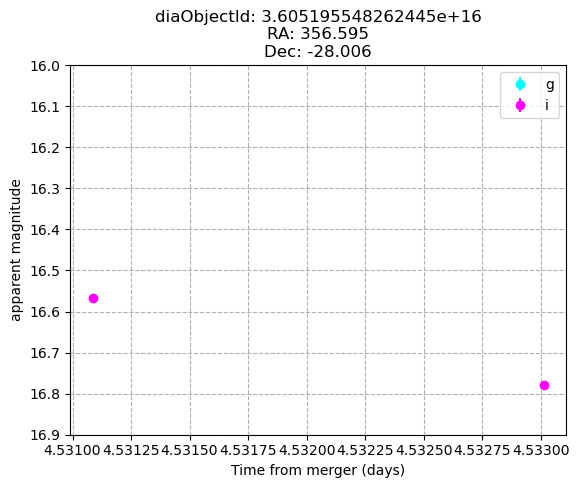

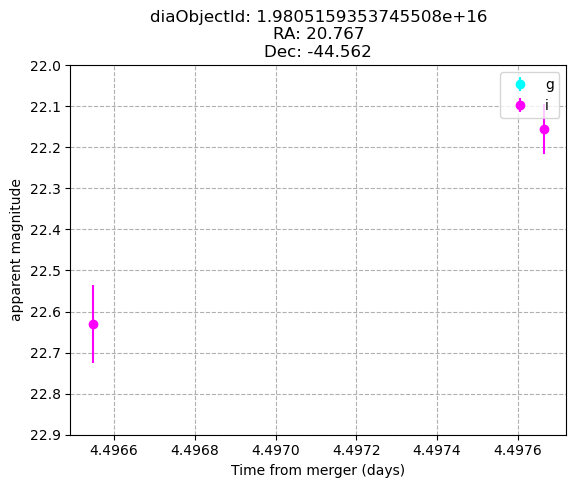

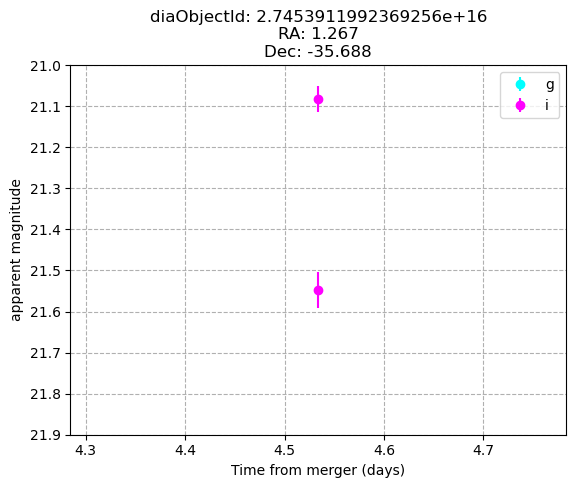

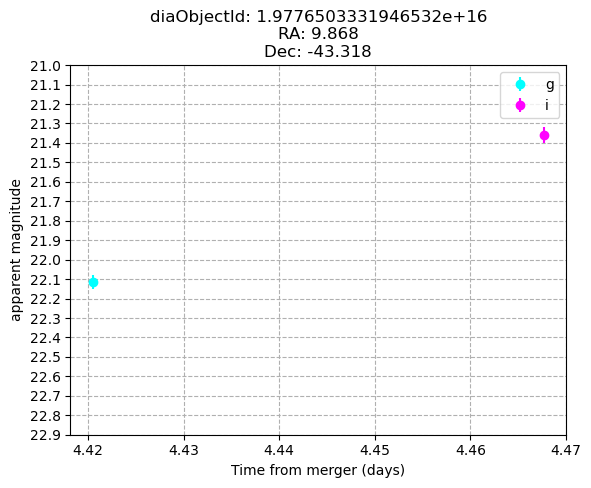

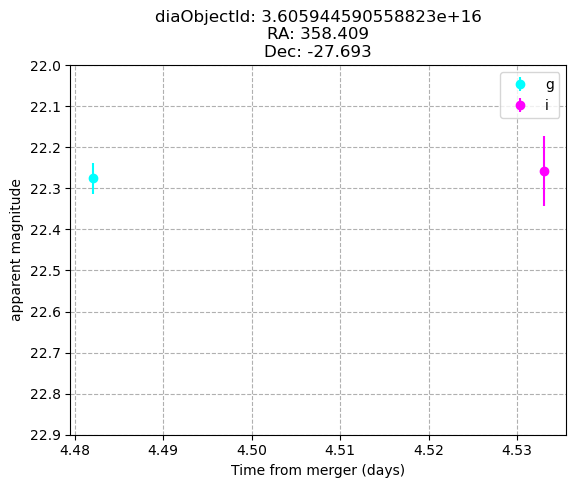

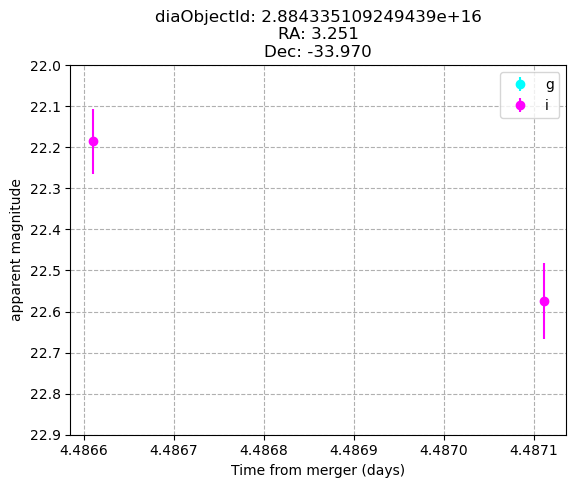

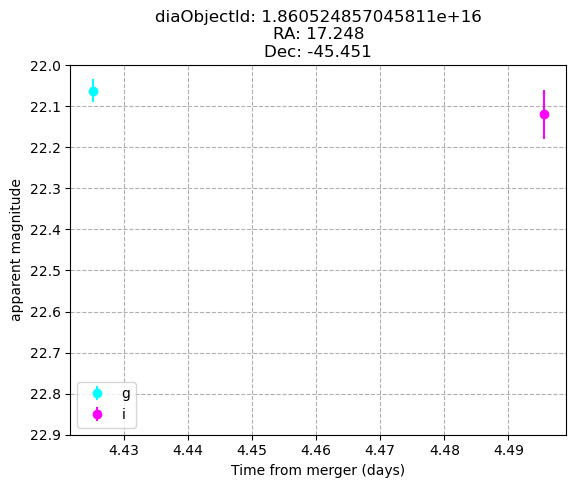

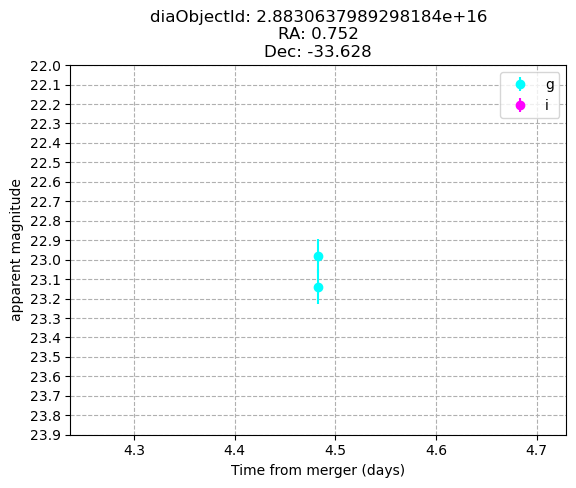

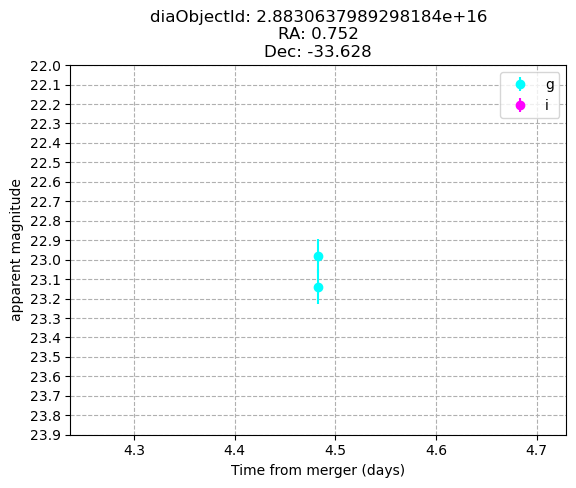

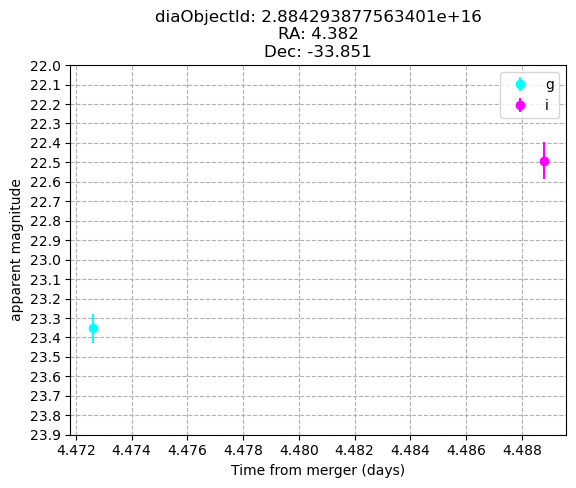

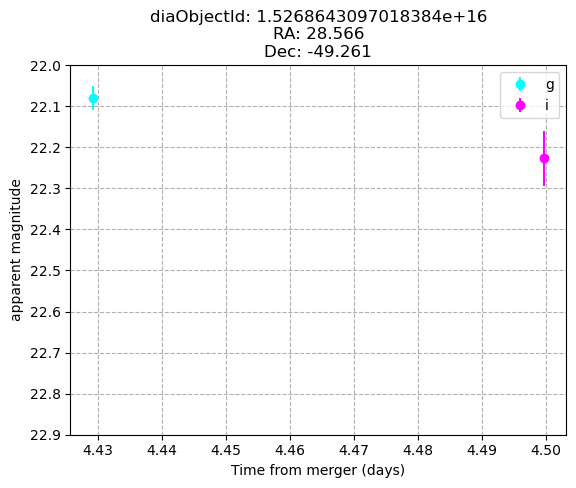

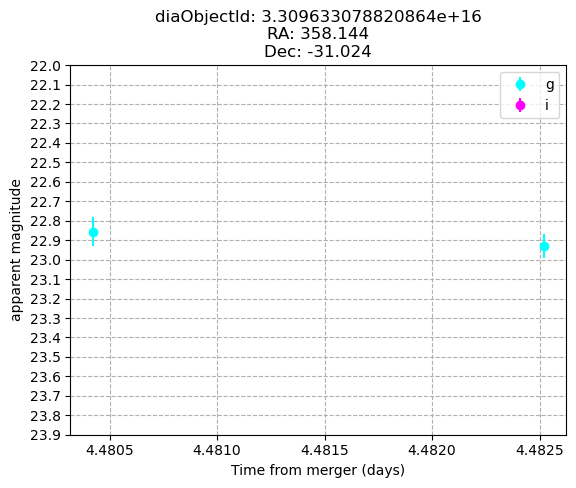

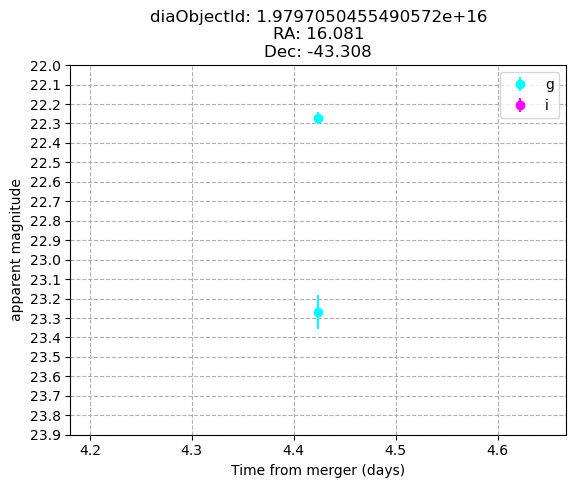

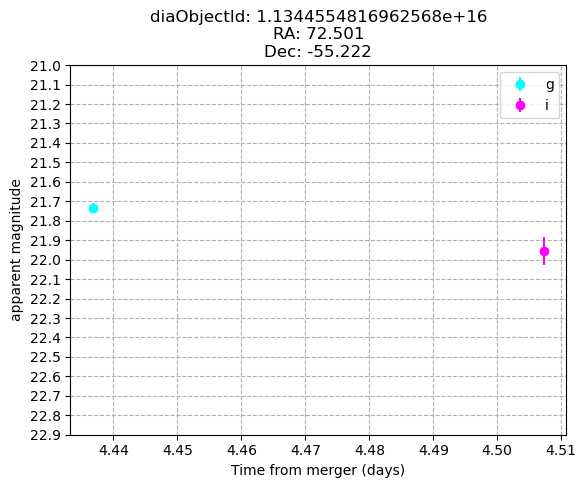

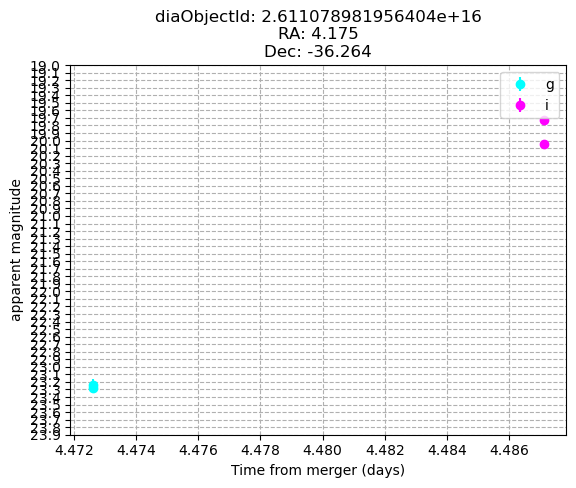

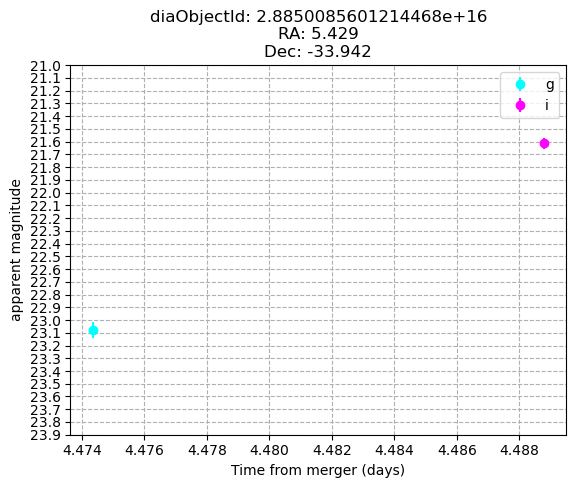

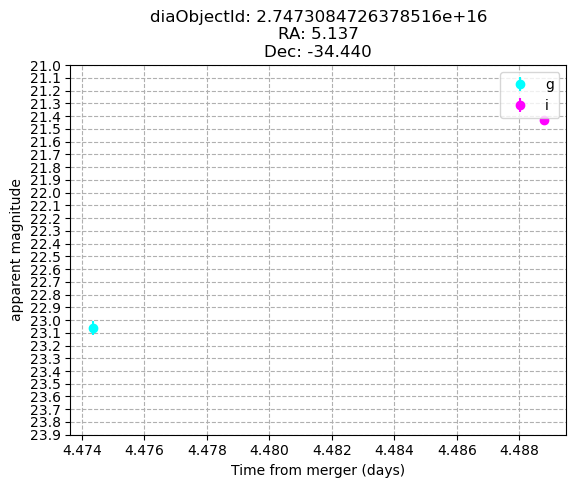

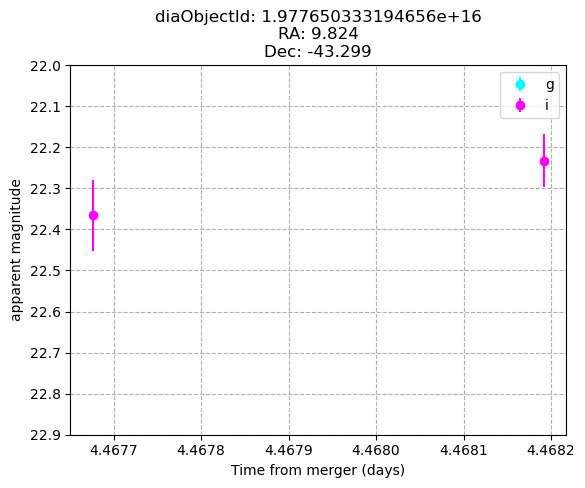

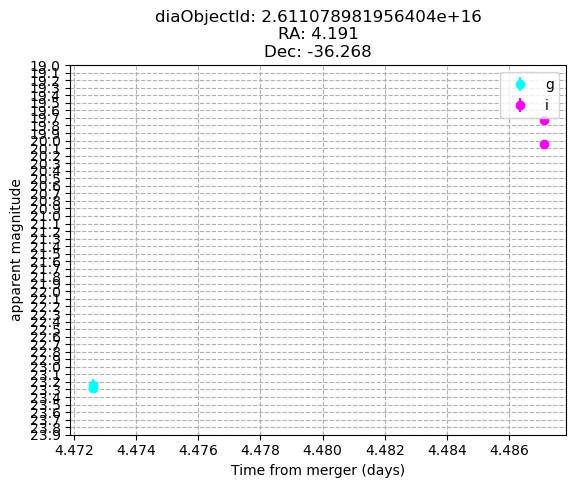

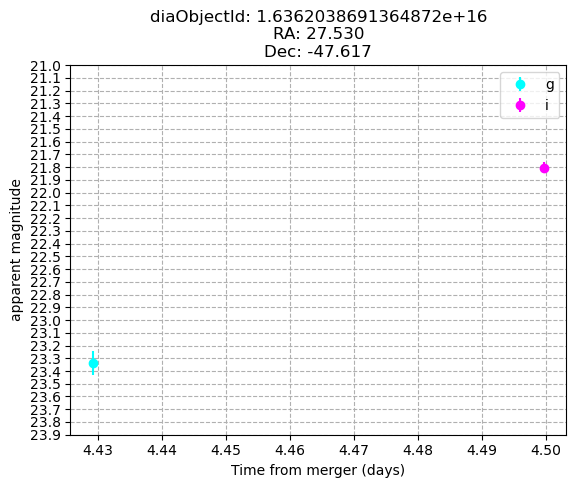

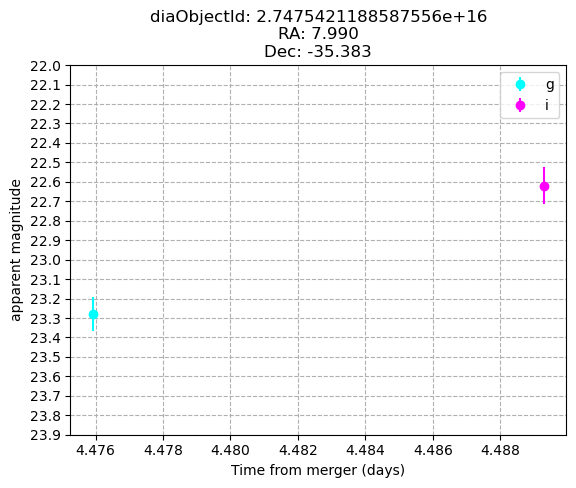

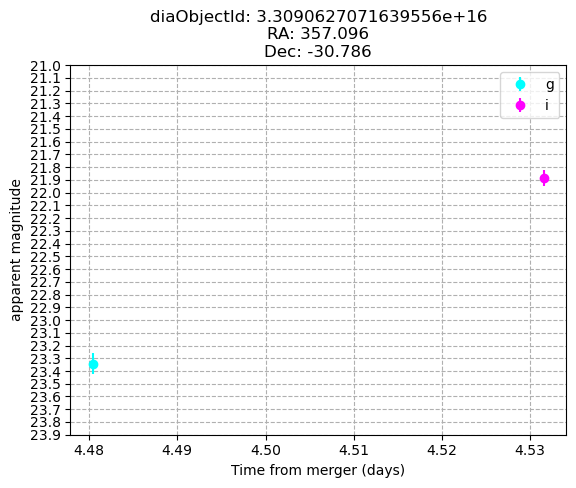

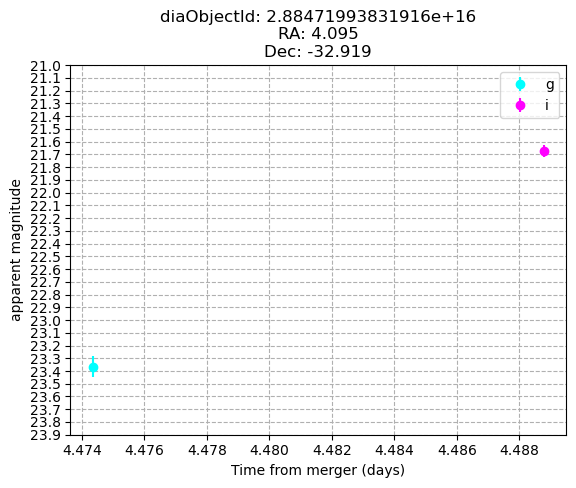

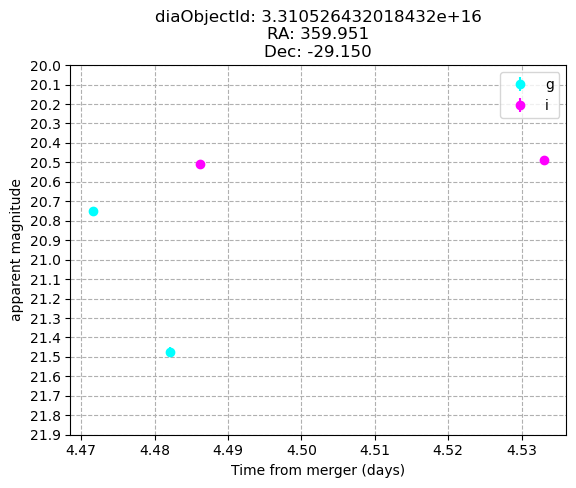

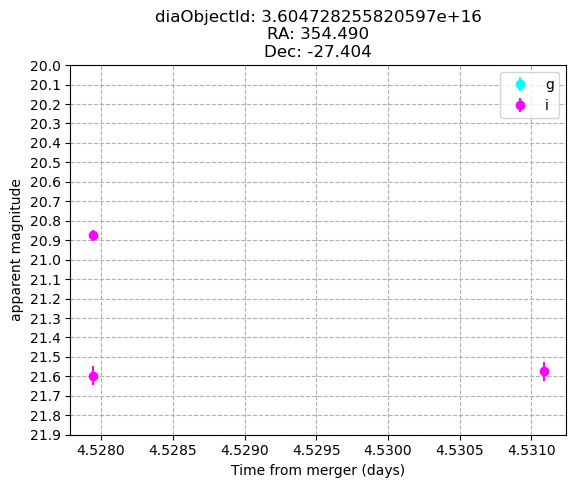

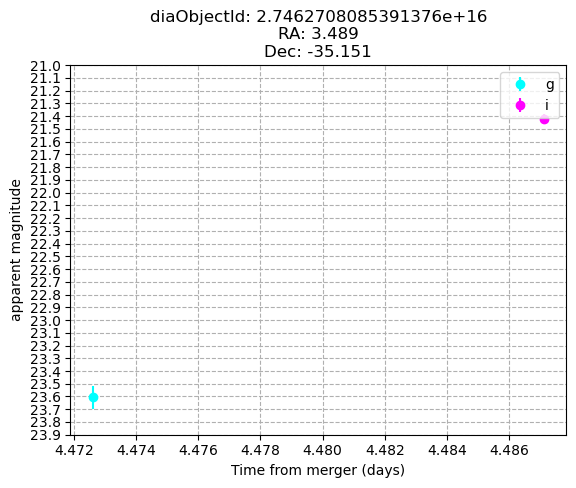

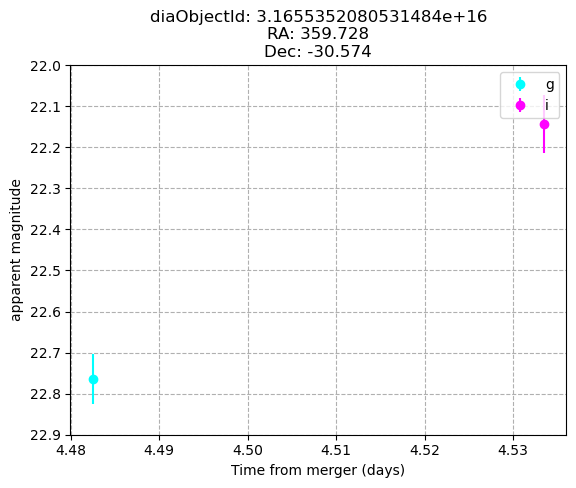

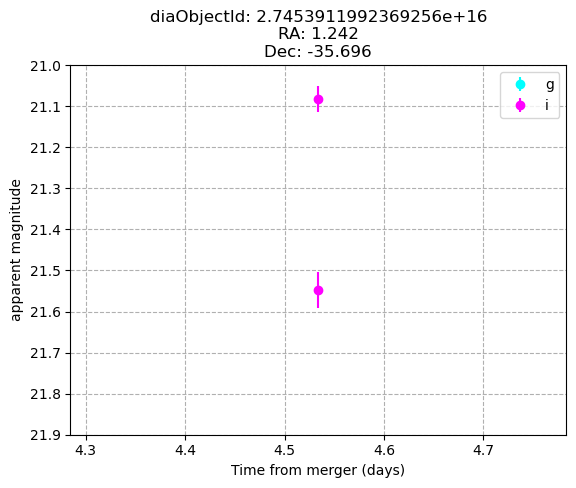

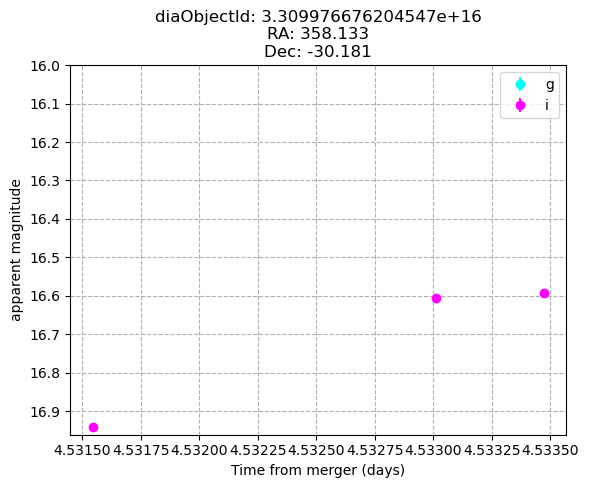

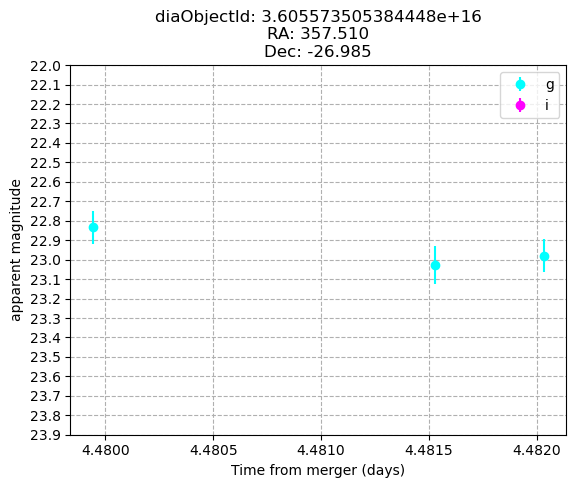

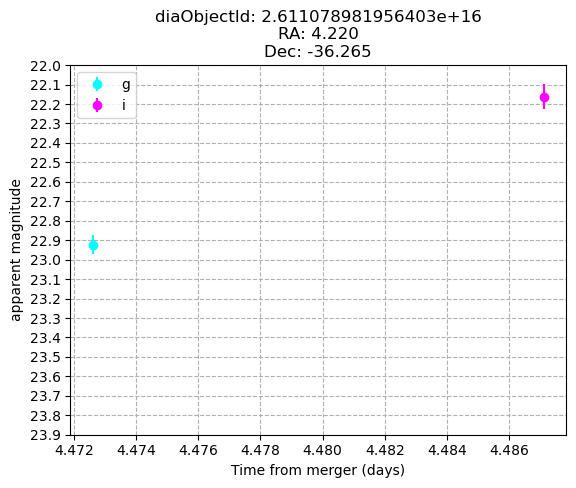

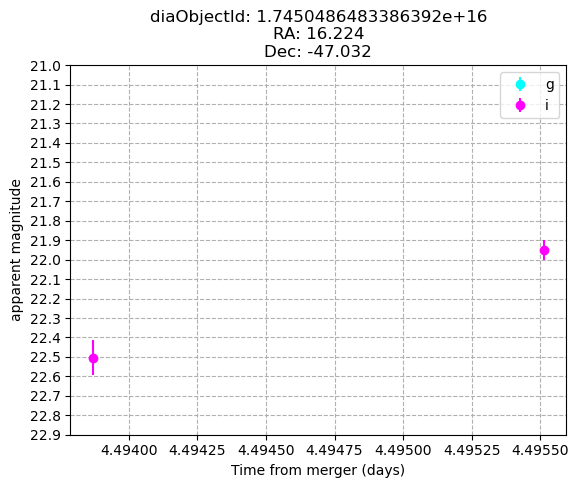

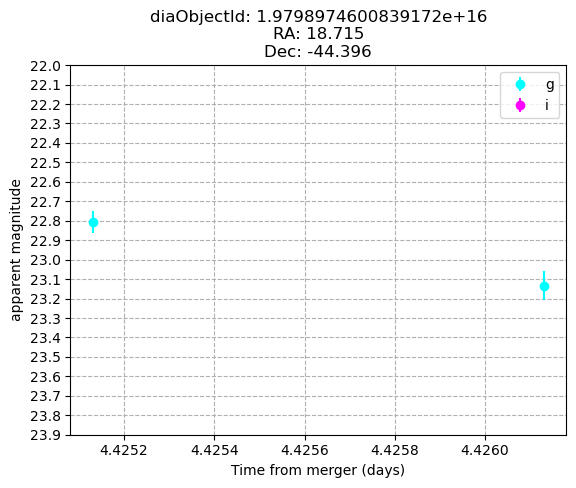

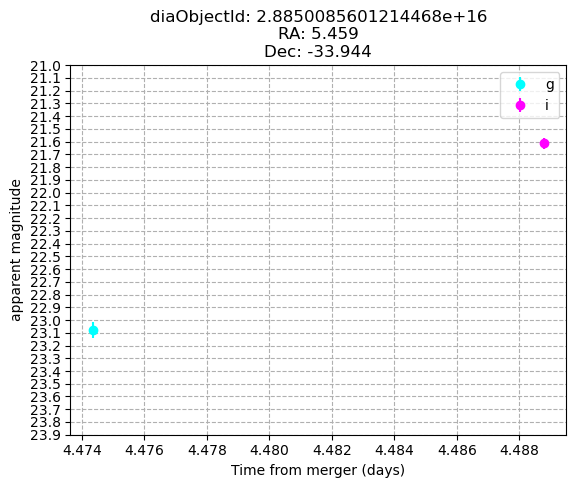

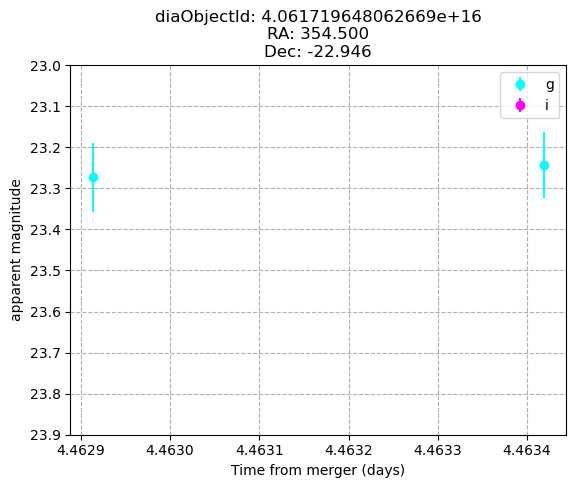

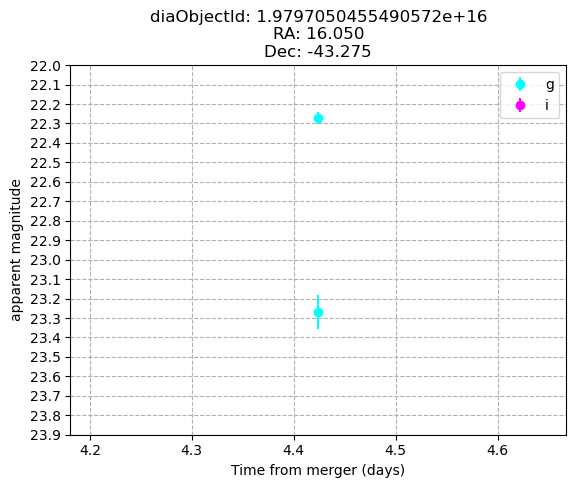

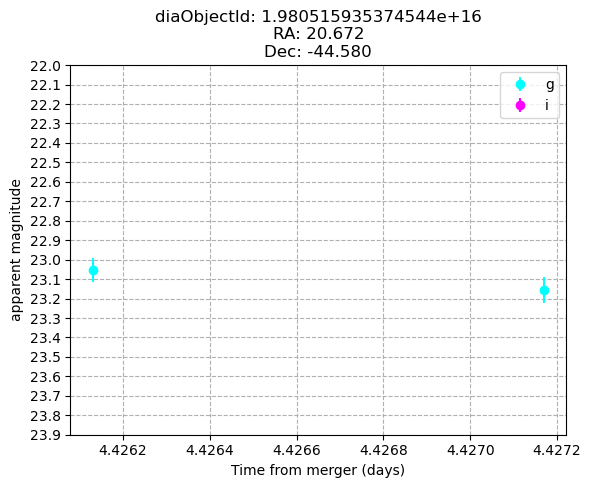

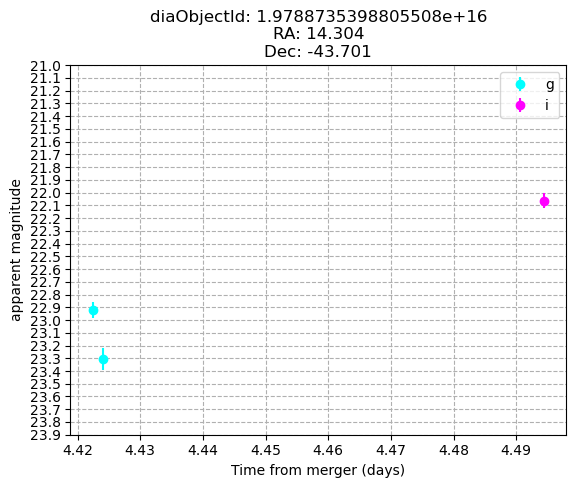

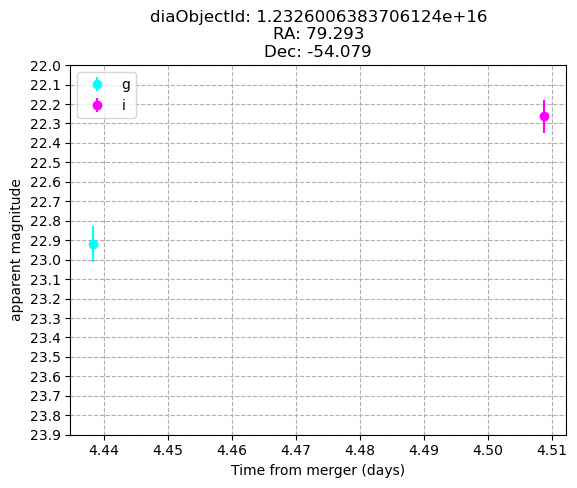

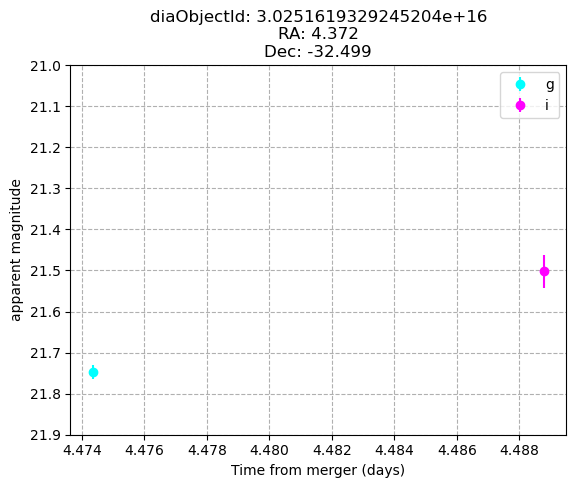

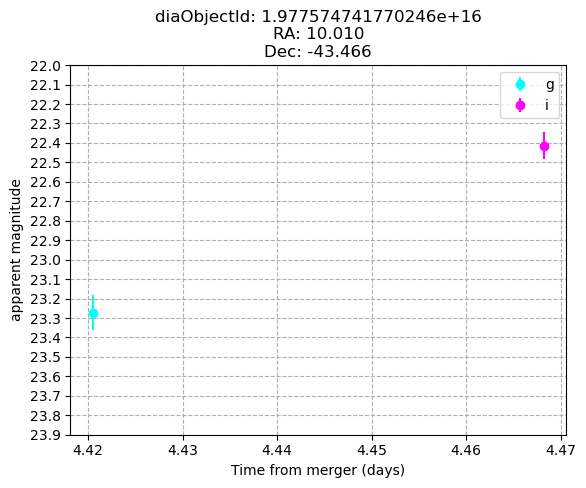

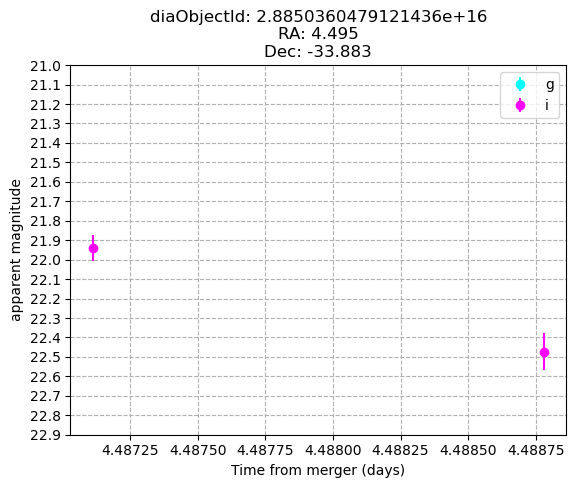

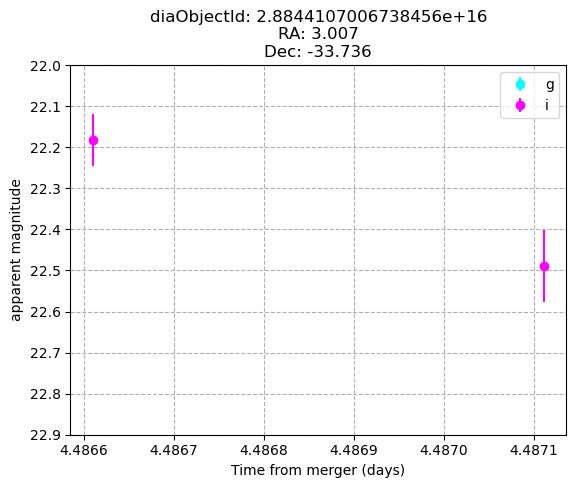

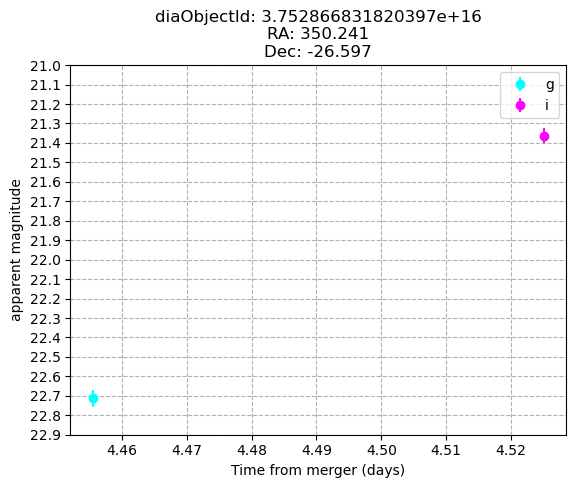

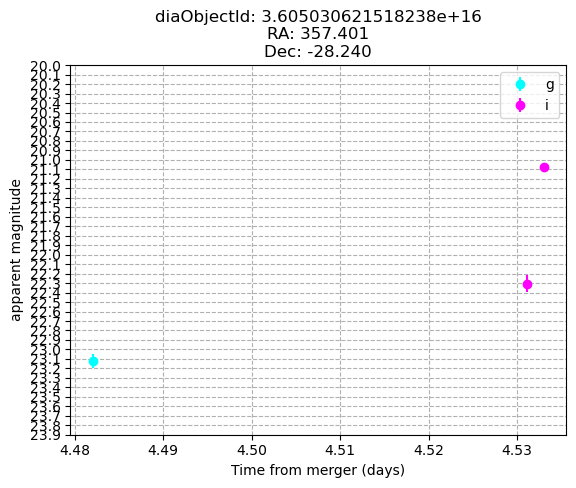

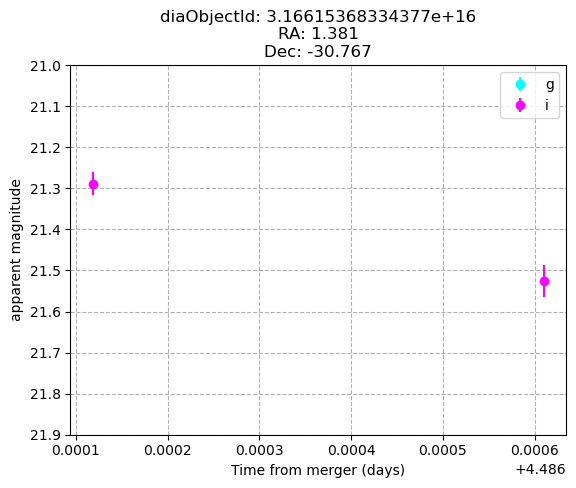

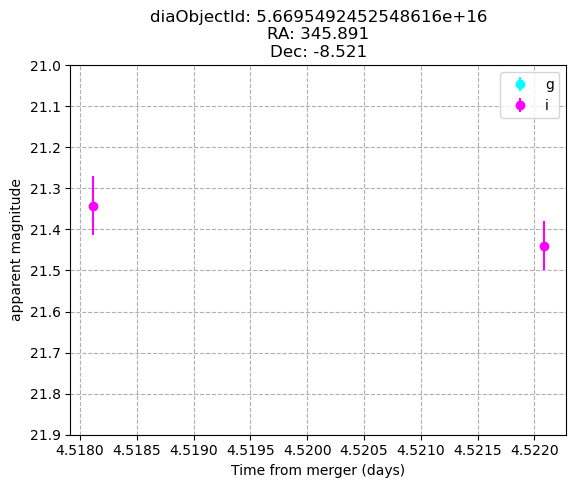

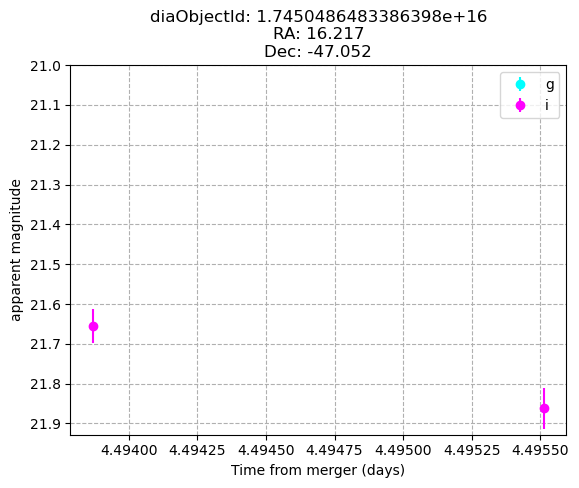

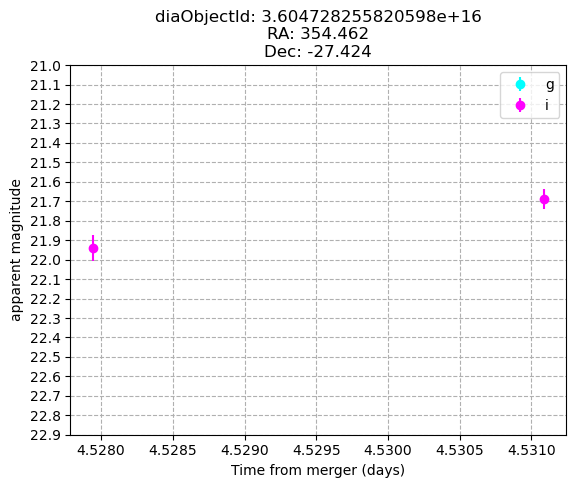

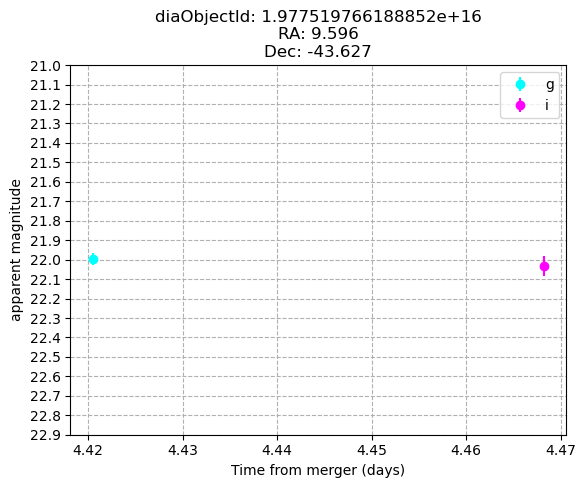

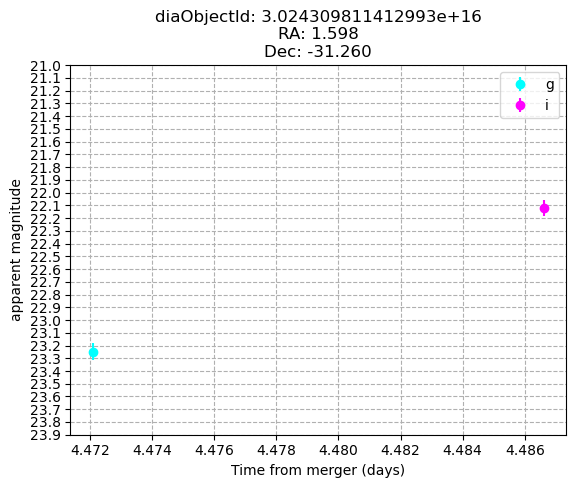

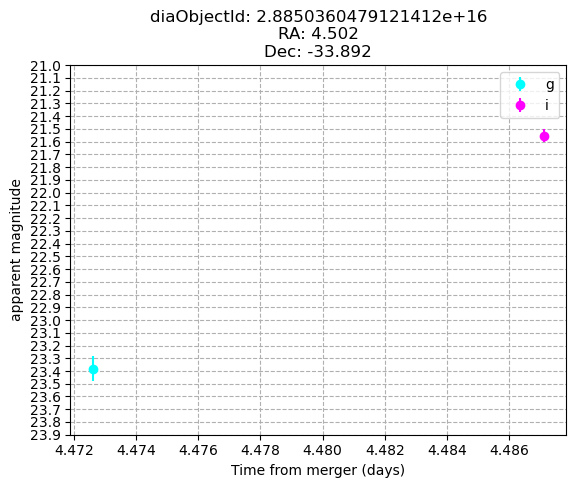

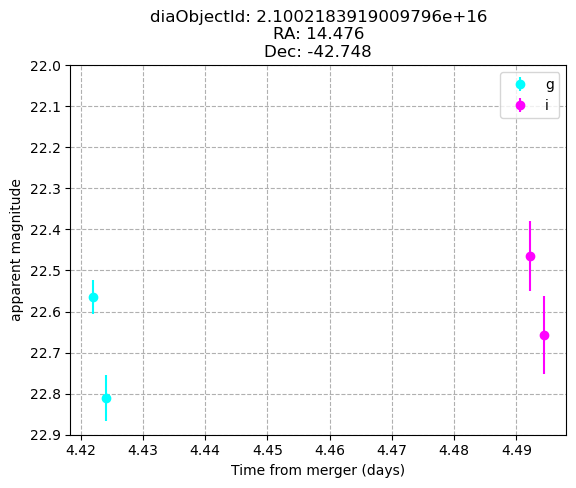

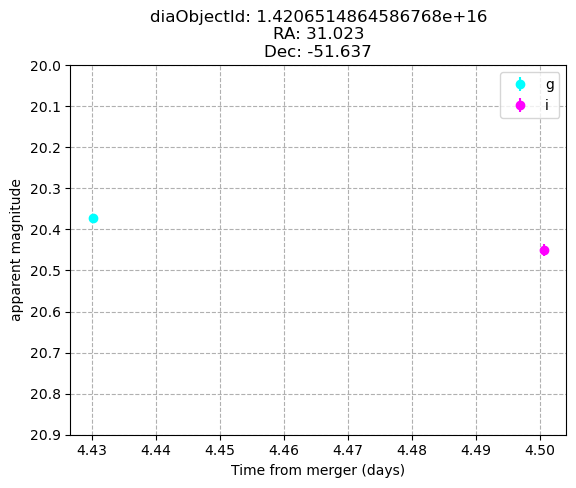

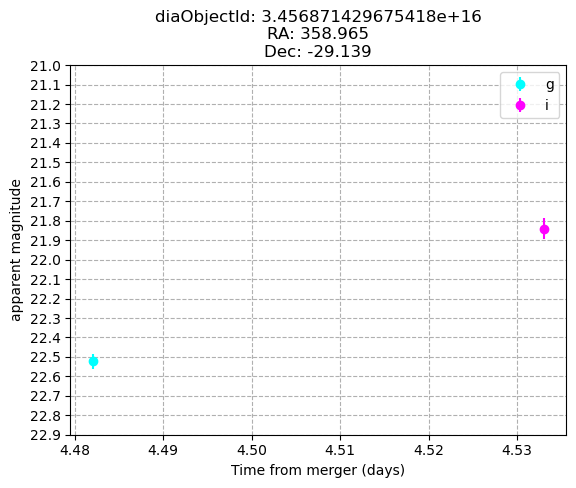

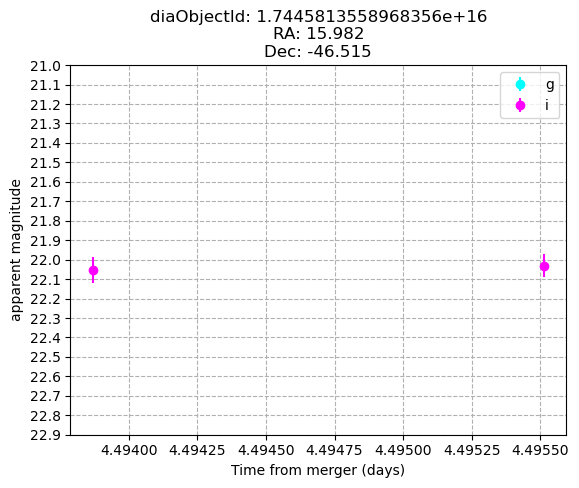

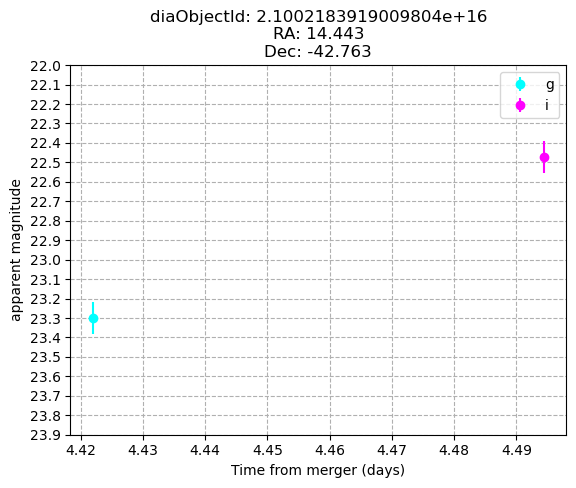

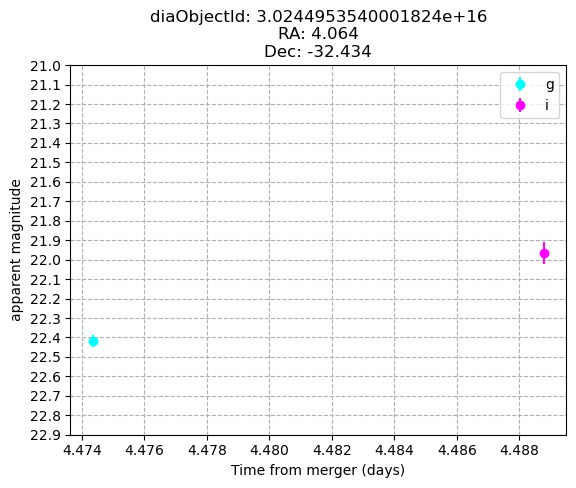

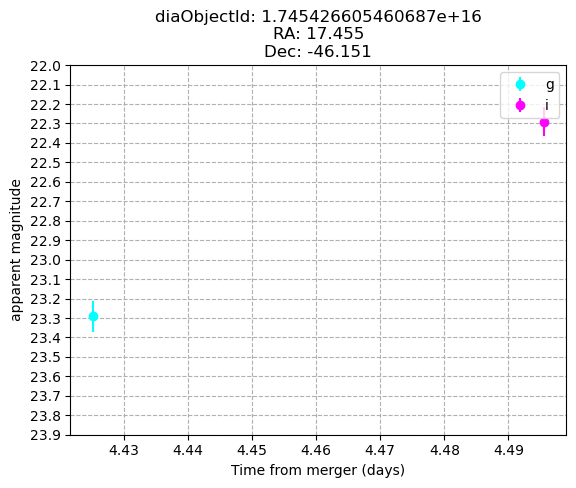

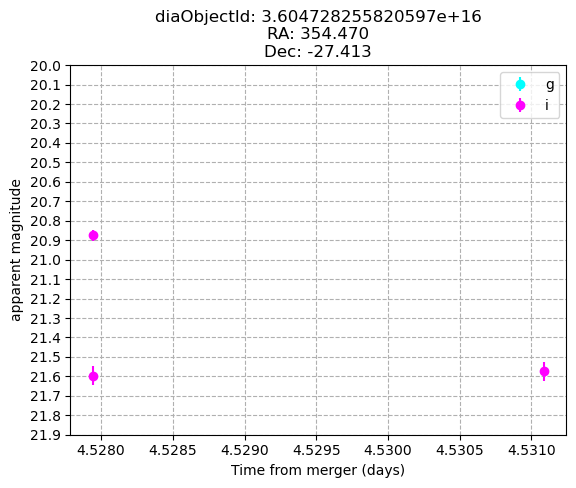

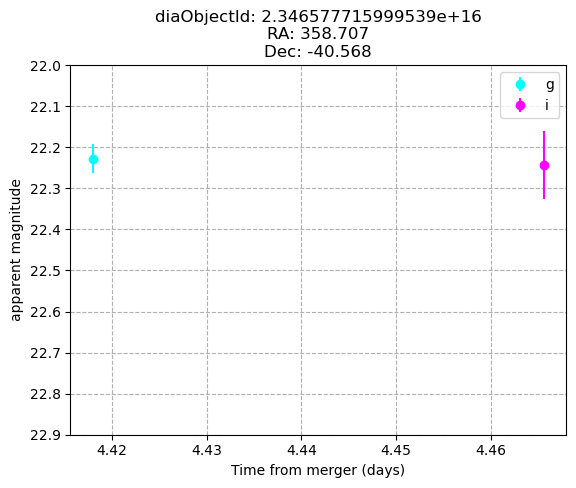

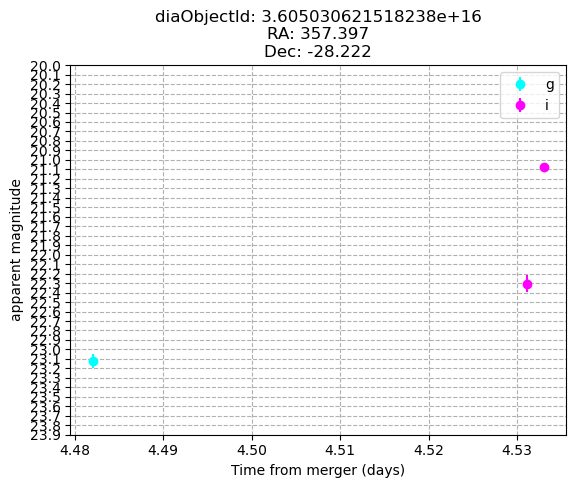

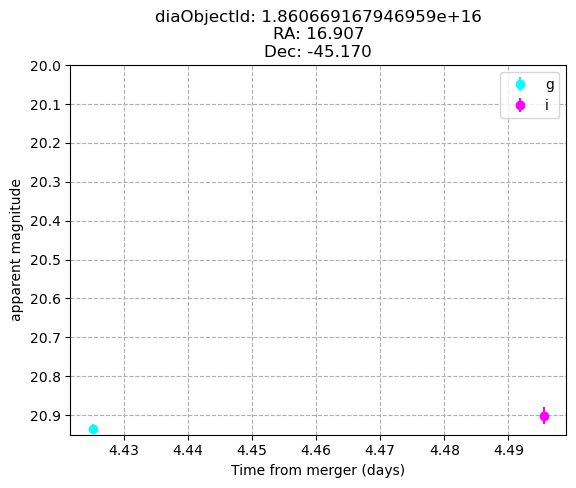

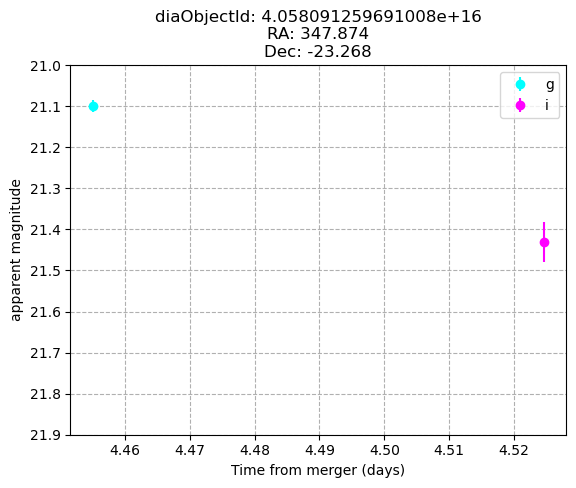

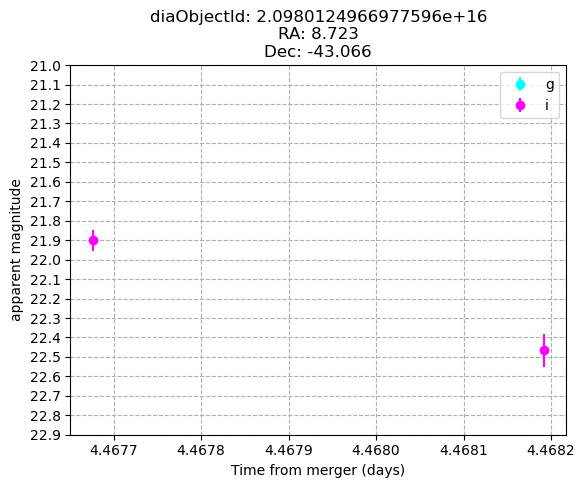

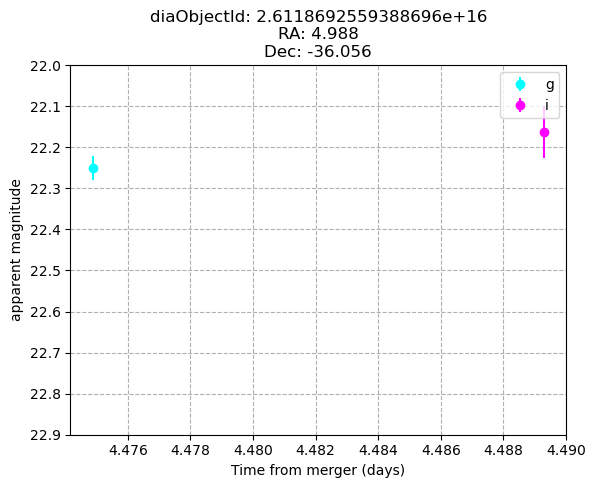

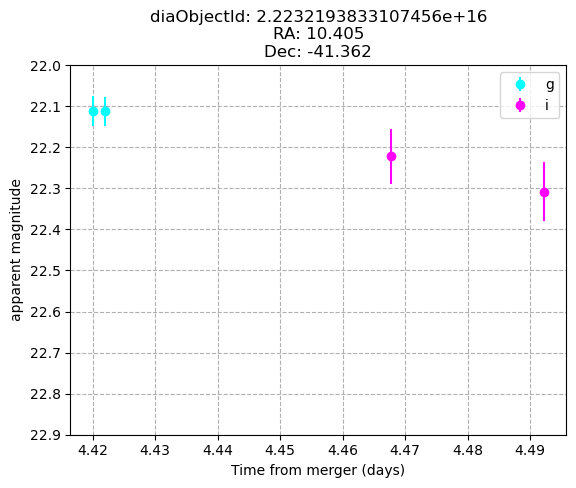

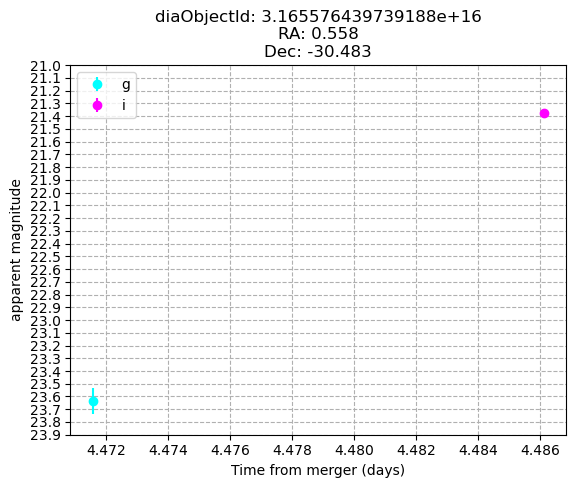

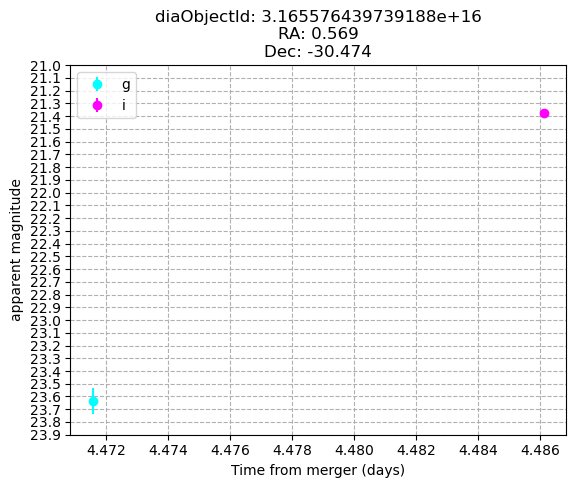

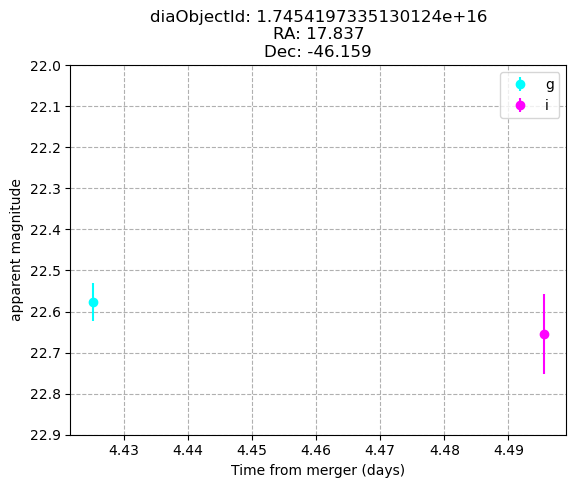

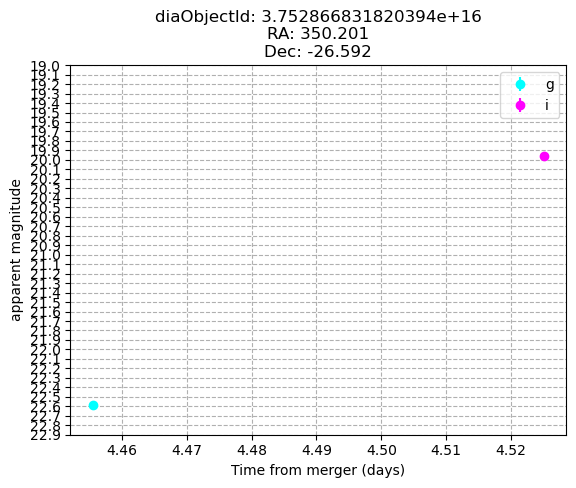

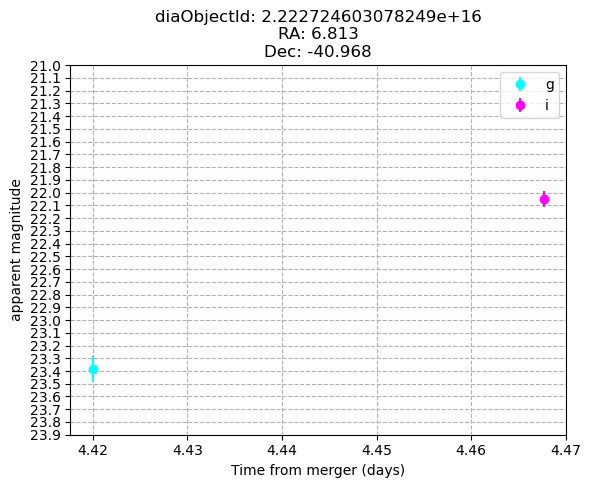

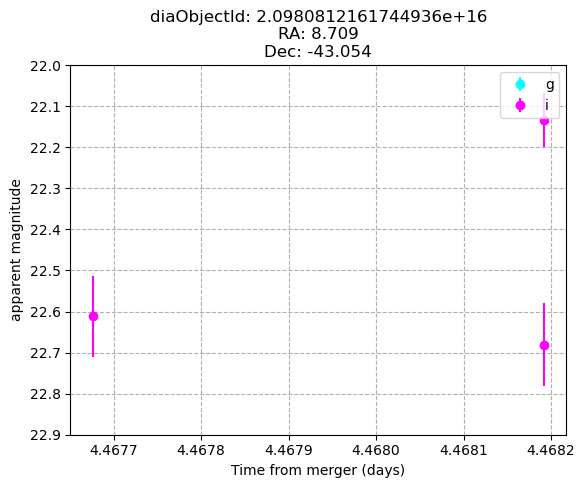

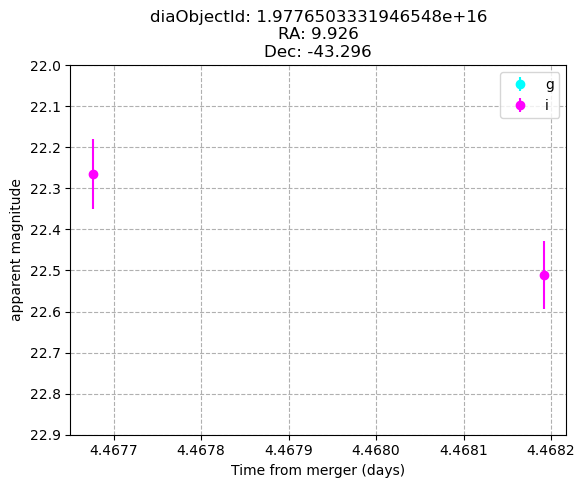

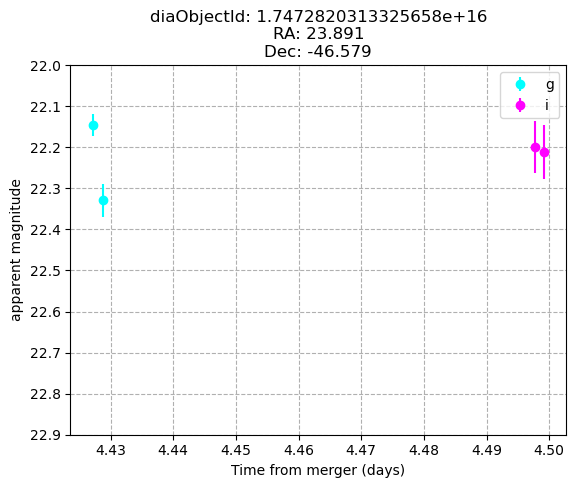

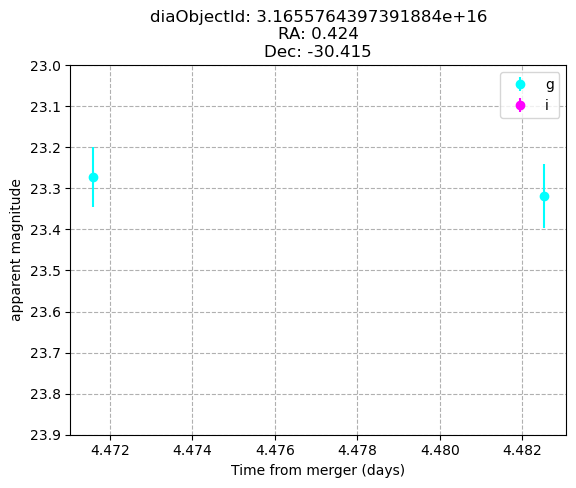

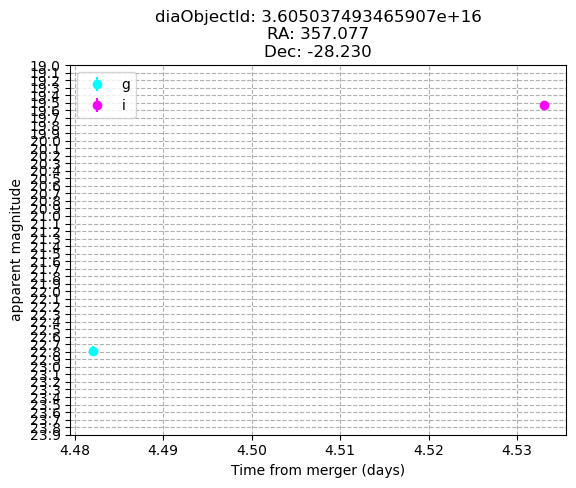

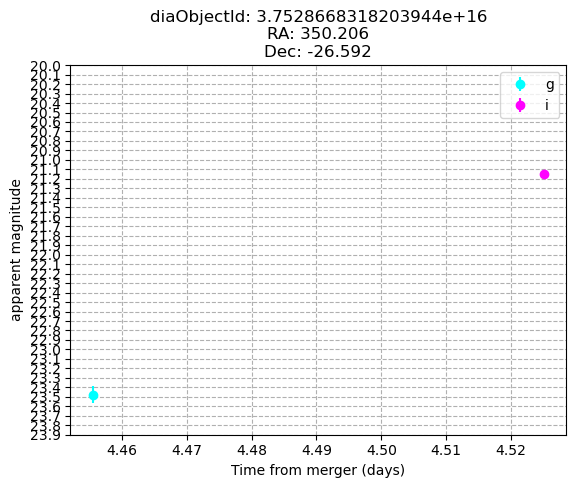

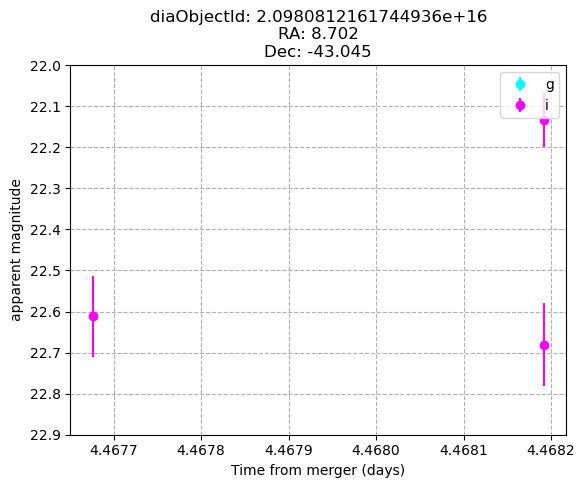

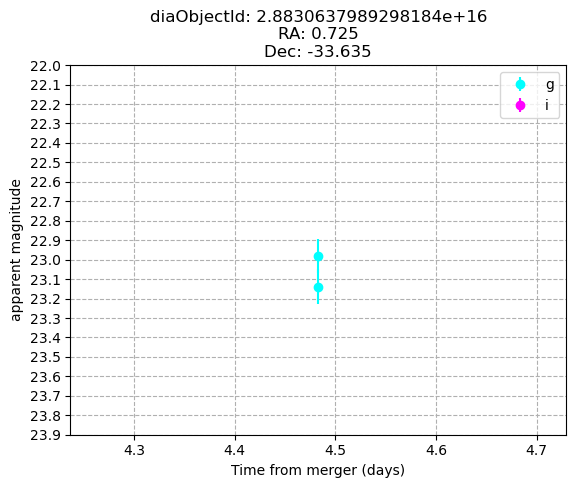

In [12]:
colors = {'g': 'cyan', 'i': 'magenta'}
t0 = Time(1446995943.36, format='gps').mjd
for i, obj in ned_dia_obj_filtered.iterrows():
    dia_objid = obj['diaObjectId']
    mask = ned_dia_src_filtered['diaObjectId'] == dia_objid
    dia_src = ned_dia_src_filtered[mask]
    if len(dia_src) < 2:
        continue
    fig,ax = plt.subplots()
    for band in np.unique(ned_dia_src_filtered['band']):
        filt = dia_src['band'] == band
        days = dia_src[filt]["midpointMjdTai"]-t0
        ax.errorbar(days, (np.array(dia_src[filt]['psfFlux']) * u.nJy).to(u.ABmag).value,
                    yerr=abs(dia_src[filt]["psfFluxErr"]/(dia_src[filt]["psfFlux"])), marker='o', 
                    color=colors[band], linestyle="None", label=band)
    ax.legend()
    ax.set_ylabel("apparent magnitude")
    ax.set_xlabel("Time from merger (days)")
    lo,hi = ax.get_ylim()
    ax.set_yticks(np.arange(np.floor(lo), np.ceil(hi), step=0.1))
    plt.gca().invert_yaxis()
    ax.grid(ls='--')
    # ax.set_title(f"diaObjectId: {testId}\nCross-matched galaxy redshift: {z:0.3f}\nRA: {ra:.3f}\nDec: {dec:.3f}")
    ax.set_title(f"diaObjectId: {obj['diaObjectId']}\nRA: {obj['ra']:.3f}\nDec: {obj['dec']:.3f}")
    fig.savefig(f"../output/DECam_Rubin_lcs_2det_S251112cm/{obj["diaObjectId"]}.jpg",dpi=180)
    plt.show()
    plt.close()
    del fig,ax

In [37]:
t0

np.float64(60991.63845324074)

There are 2800 candidates that pass our crossmatching cuts. We can reduce them to a reasonable number by removing candidates on top of distant galaxies, since this event is at 92 Mpc.